In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase

import warnings

from mpl_toolkits import mplot3d

from qutip import *

from ase.build import bulk

import pycce.filter

import scipy.stats as stats
from scipy.optimize import curve_fit

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\Daniel Low\Anaconda3\lib\site-packages\qutip\__init__.py:61: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.12.
  .format(_cy_require, _Cython.__version__)


In [3]:
import matplotlib as mpl  
plt.style.use('plot_style.txt')
# mpl.rcParams['figure.figsize'] = [12.0, 8.0]
# mpl.rcParams['xtick.labelsize'] = 15


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
"""set up seed for T2 calculation of varying concentration"""
seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [29]:
"generating nuclear spin bath for a diamond crystal structure, includes isotopes"

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)

atoms['14C'].gyro = 0
atoms['14C'].spin = 0


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"setup for visualization and coherence calculation"

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# The code already knows most existing isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

''

In [7]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"conventional"
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 2
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

"general"
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

"random sampling of bath states"
# Number of random bath states to sample over
n_bath_states = 10

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence')

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"


def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit






#popt: Optimized parameters
#pcov: matrix of covariance.
popt1,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
popt2,pcov2 = curve_fit(coherence_fit,time_space, l_gcce.real)

print ("popt_gen :\n", popt1)
print ("pcov_gen :\n", pcov1)

print ("popt_samp :\n", popt2)
print ("pcov_samp :\n", pcov2)

T2_gen = popt1


T2_samp = popt2








popt_gen :
 [2.52761]
pcov_gen :
 [[0.00779]]
popt_samp :
 [2.37766]
pcov_samp :
 [[0.00606]]


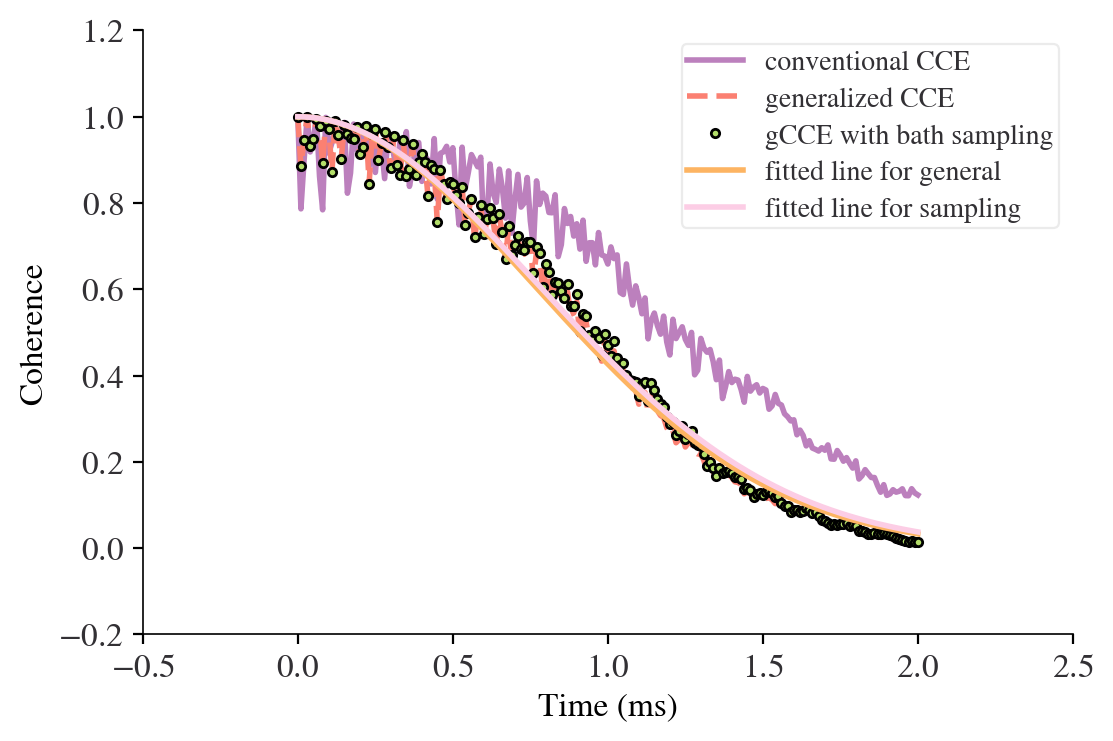

In [6]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')

y_gen = coherence_fit(time_space, T2_gen)# calculates the y value using the Gaussian function
plt.plot(time_space,y_gen,'-', label='fitted line for general')
y_samp = coherence_fit(time_space, T2_samp)
plt.plot(time_space,y_samp,'-', label='fitted line for sampling')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_1.png")

## 13C concentration 0.002 - 0.04 (100 steps)

In [15]:
""" T2 range for varying 13C concentration """

repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G


T2_range_conc = []

for i in np.linspace(0.002, 0.04, repeats):
    diamond.add_isotopes(('13C', i))
    diamond.isotopes['C']['14C'] = 0.001
    atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=('14N', [0.5, 0.5, 0.5]), seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
    T2_range_conc.append(popt[0])

    


[0.00883]


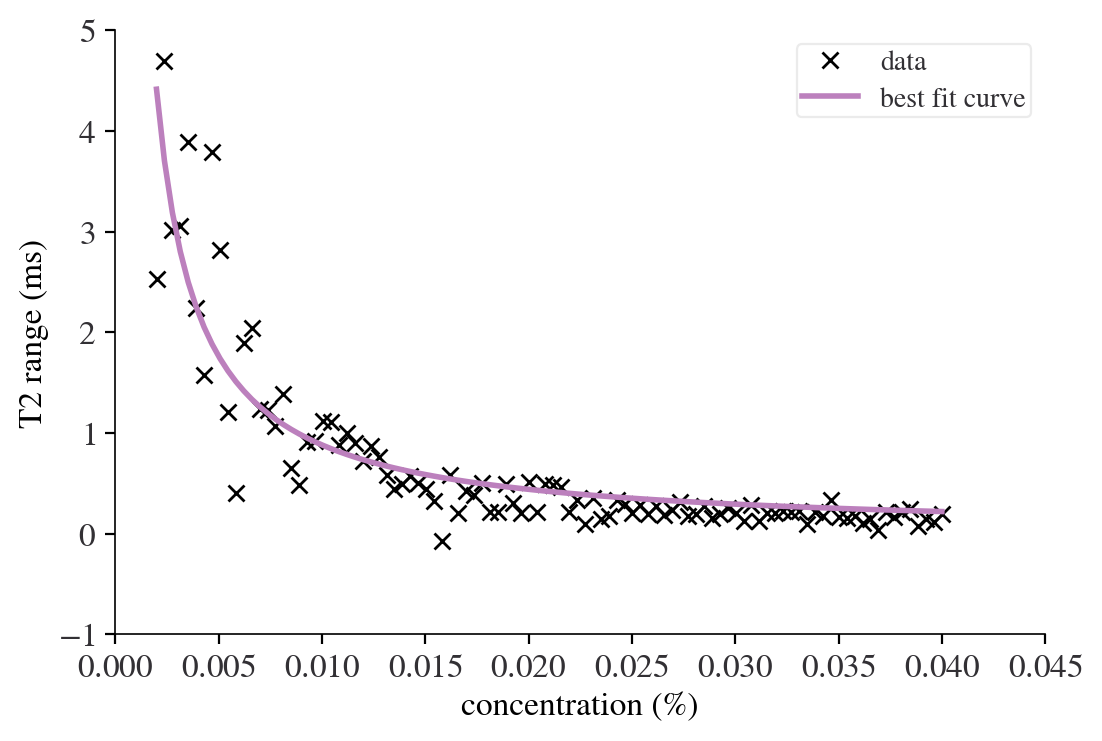

In [59]:
concentration = np.linspace(0.002, 0.04, repeats)

def conc_fit(x,a):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = a/x**(1)
    
    return fit

popt,pcov = curve_fit(conc_fit,concentration, T2_range_conc)

print(popt)

plt.figure()
plt.plot(concentration, T2_range_conc, 'rx', label='data')
plt.plot(concentration, conc_fit(concentration,popt[0]), label='best fit curve')
plt.ylabel('T2 range (ms)')
plt.xlabel('concentration (%)')
plt.legend(loc='best')
# plt.yscale('log')
# plt.xscale('log')
#plt.title("T2 distribution for varying C-13 isotope concentrations on a single NV")

plt.savefig("T2distribution_1.1percentC13_fixedseed.png")

## distance between one lone 14 N and NV center, 0.5 - 1.5 coord

In [53]:
import time


""" T2 range for varying distance between NV and one lone 14N impurity """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

repeats = 50
time_space = np.linspace(0, 1.5, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 100  # in A
# Cluster cutoff radius
r_dipole = 20  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

distances_near = np.linspace(0.51, 0.7, repeats)
T2_range_dist_near = []
T2_range_dist_near_err = []
n = 0
for i in distances_near:
    n = n+1
    starttime = time.perf_counter()
    
    diamond.add_isotopes(('13C', 0.011))
    atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [i, i, i])], seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_range_dist_near.append(T2_gen[0])
    T2_range_dist_near_err.append(T2_var[0][0])
    
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)

    
distances_far = np.linspace(0.7, 1.5, 30)
T2_range_dist_far = []
T2_range_dist_far_err = []
n = 0
for i in distances_far:
    n = n+1
    starttime = time.perf_counter()
    
    diamond.add_isotopes(('13C', 0.011))
    atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [i, i, i])], seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_range_dist_far.append(T2_gen[0])
    T2_range_dist_far_err.append(T2_var[0][0])
    
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)

-939.8247059000423 secs for calc 1
-672.8340766999172 secs for calc 2
-822.201160900062 secs for calc 3
-657.0758192000212 secs for calc 4
-825.5213128000032 secs for calc 5
-654.8026477000676 secs for calc 6
-834.7931267000968 secs for calc 7
-654.5824955999851 secs for calc 8
-817.019933899981 secs for calc 9
-651.1182111999951 secs for calc 10
-817.069221099955 secs for calc 11
-651.4701667999616 secs for calc 12
-817.7602175000357 secs for calc 13
-649.8776513000485 secs for calc 14
-816.9043388999999 secs for calc 15
-648.5976466001011 secs for calc 16
-816.8261392000131 secs for calc 17
-651.9136662000092 secs for calc 18
-816.9361608999316 secs for calc 19
-651.4739419999532 secs for calc 20
-818.3303281000117 secs for calc 21
-649.3452328999992 secs for calc 22
-815.9033102999674 secs for calc 23
-648.1964592000004 secs for calc 24
-820.1283853000496 secs for calc 25
-652.138790099998 secs for calc 26
-816.1883343999507 secs for calc 27
-650.7803287999704 secs for calc 28
-822.

In [30]:
distances = np.concatenate([distances_near,distances_far])
T2_range_dist = np.concatenate([T2_range_dist_near,T2_range_dist_far])
T2_range_dist_err = np.concatenate([T2_range_dist_near_err,T2_range_dist_far_err])

T2_popfiterror = 0.0026045948996093372
T2_range_dist_trueerr = np.multiply( np.add( np.divide( T2_range_dist_err,T2_range_dist ),T2_popfiterror ),T2_range_dist )

def position_fit(x,a,b,c,d,e):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = a - abs(b)/((c*x*3.57+d)**2+e)
    
    return fit

popt,pcov = curve_fit(position_fit, distances, T2_range_dist, sigma=T2_range_dist_trueerr)

print(popt)

plt.figure()
plt.errorbar(distances*0.357, T2_range_dist, yerr=T2_range_dist_trueerr, fmt='.', color='w', ecolor='k', elinewidth=1, capsize=2, label='data')
distances_fit = np.linspace(0.5,1.6, 100)

plt.plot(distances_fit*0.357, position_fit(distances_fit,popt[0],popt[1],popt[2],popt[3],popt[4]), '-',color='b', label='negative lorentzian fit')

def position_fit(x,a,b,c,d,e):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = abs(a)*( (b/(e*x*3.57 - d))**12 - 2*(b/(e*x*3.57 -d))**6 ) + c
    
    return fit

popt,pcov = curve_fit(position_fit, distances, T2_range_dist, sigma=T2_range_dist_trueerr)
plt.plot(distances_fit*0.357, position_fit(distances_fit,popt[0],popt[1],popt[2],popt[3],popt[4]), '-',color='g', label='anharmonic fit')

plt.ylabel('$T_2$ range (ms)',size=15)
plt.xlabel('distance between NV defect and lone $^{14}$N atom (nm)',size=15)
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
#plt.title("T2 distribution for varying distance between a lone 14N and NV")

plt.savefig("T2distribution_14Nvarieddistance_fixedseed.png")


datasavefile = 'T2distribution_14Nvarieddistance_fixedseed.csv'
data_N_dist_T2 = {'distances':distances, 'T2_range_dist':T2_range_dist, 'T2_range_dist_err':T2_range_dist_err, 'T2_range_dist_trueerr':T2_range_dist_trueerr}


df = pd.DataFrame(data = data_N_dist_T2)
df.to_csv(datasavefile)

NameError: name 'distances_near' is not defined

[    1.07611 -2958.9997   -676.774      21.8092     51.03058]


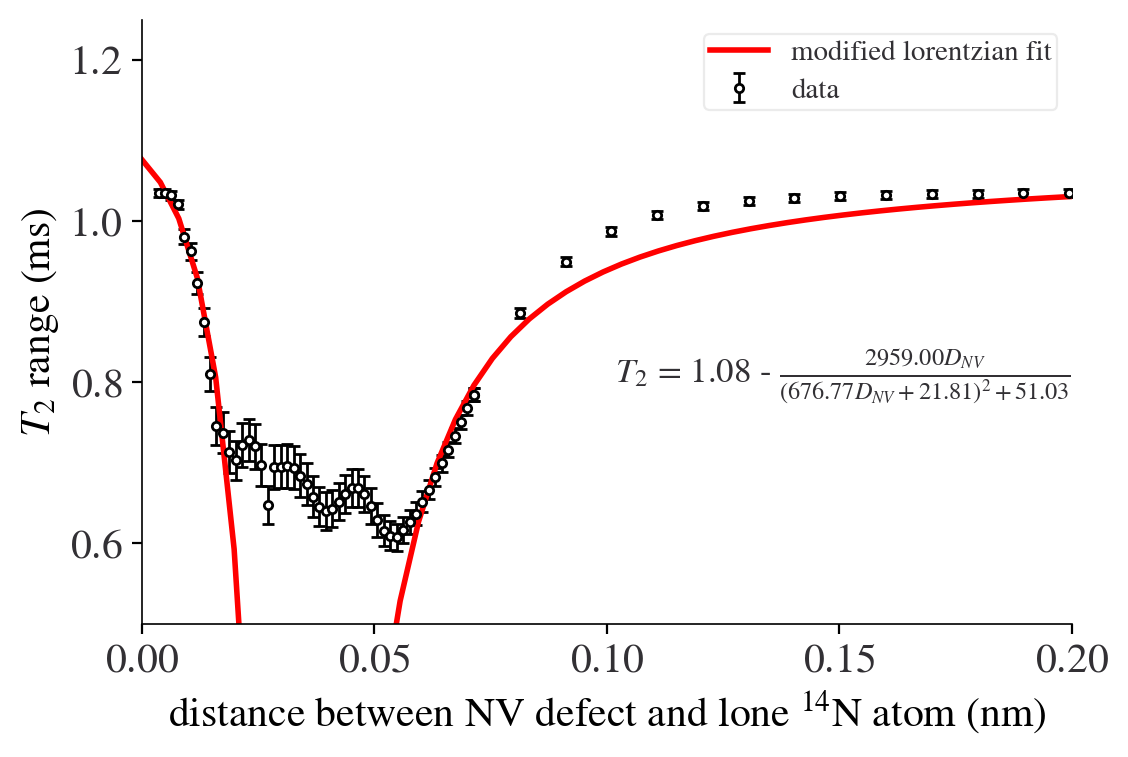

In [68]:
datasavefile = 'Nitrogen\T2distribution_14Nvarieddistance_fixedseed.csv'
data_N_dist_T2 = pd.read_csv(datasavefile)



distances = data_N_dist_T2['distances'] - 0.5
T2_range_dist = data_N_dist_T2['T2_range_dist']
T2_range_dist_err = data_N_dist_T2['T2_range_dist_err']

front = 12
last = 40
# print(data_N_dist_T2.head(front))
# print(data_N_dist_T2.tail(last))


good_data = pd.concat([data_N_dist_T2.head(front),data_N_dist_T2.tail(last)])
good_distances = good_data['distances'] - 0.5
good_T2_range_dist = good_data['T2_range_dist']
good_T2_range_dist_err = good_data['T2_range_dist_err']


T2_popfiterror = 0.26045948996093372
T2_range_dist_trueerr = np.multiply( np.add( np.divide( T2_range_dist_err,T2_range_dist ),T2_popfiterror ),T2_range_dist )
good_T2_range_dist_trueerr = np.multiply( np.add( np.divide( good_T2_range_dist_err,good_T2_range_dist ),T2_popfiterror ),good_T2_range_dist )

def position_fit(x,a,b,c,d,e):
    "fit Lorentzian"
    
    fit = a - abs(b)*x*0.357/((c*x*0.357+d)**2+e)
    
    return fit

popt,pcov = curve_fit(position_fit, good_distances, good_T2_range_dist)

print(popt)

plt.figure()
plt.errorbar((distances)*0.357, T2_range_dist, yerr=T2_range_dist_err, fmt='w.', ecolor='k', elinewidth=1, capsize=2, label='data')
distances_fit = np.linspace(0,1.1, 100)

plt.plot(distances_fit*0.357, position_fit(distances_fit,popt[0],popt[1],popt[2],popt[3],popt[4]), '-',color='r', label='modified lorentzian fit')

# def position_fit(x,a,b,c,d,e):
#     "fit anharmonic"
    
#     fit = abs(a)*( (b/(e*x*3.57 - d))**12 - 2*(b/(e*x*3.57 -d))**6 ) + c
    
#     return fit

# popt,pcov = curve_fit(position_fit, distances, T2_range_dist, sigma=T2_range_dist_trueerr)
# distances_fit = np.linspace(0.5,1.6, 100)
# plt.plot(distances_fit*0.357, position_fit(distances_fit,popt[0],popt[1],popt[2],popt[3],popt[4]), '-',color='g', label='anharmonic fit')

plt.ylabel('$T_2$ range (ms)',size=15)
plt.xlabel('distance between NV defect and lone $^{14}$N atom (nm)',size=15)
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best',fontsize='x-small')
plt.xlim(0,0.2)
plt.ylim(0.5,1.25)
plt.text(0.1,0.8, r' $T_2$ = 1.08 - $\frac{{ 2959.00 D_{NV} }}{{ (676.77 D_{NV} + 21.81)^2 + 51.03 }} $ ', fontsize='small')
# plt.text(0.1,0.8, ' $T_2$ = 1.08 - $\frac{{ d_N }}{{ d_N^2 + 51.03 }} $ ', fontsize='x-small')


#plt.title("T2 distribution for varying distance between a lone 14N and NV")

plt.savefig("T2distribution_14Nvarieddistance_fixedseed.png")


In [44]:
distances = np.concatenate([distances_near,distances_far])
T2_range_dist = np.concatenate([T2_range_dist_near,T2_range_dist_far])
T2_range_dist_err = np.concatenate([T2_range_dist_near_err,T2_range_dist_far_err])

def position_fit(x,a,b,c,d,e):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = a - abs(b)/((c*x*3.57+d)**2+e)
    
    return fit

# def position_fit(x,a,b,c):
#     "fit coherence function to a negative squared exponential function with time constant T2"
    
#     fit = abs(a)*( (b/(x*3.57))**12 - 2*(b/(x*3.57))**6 ) + c
    
#     return fit

# popt,pcov = curve_fit(position_fit, distances, T2_range_dist)

print(popt)

plt.figure()
plt.errorbar(distances_near*0.357, T2_range_dist_near, yerr=T2_range_dist_near_err, fmt='.', color='w', ecolor='k', elinewidth=1, capsize=2, label='data')
distances_fit = np.linspace(0.5,1.6, 100)
# distances_fit = np.linspace(0.5,1.5, 100)
# plt.plot(distances_fit, position_fit(distances_fit,popt[0],popt[1],popt[2]), '-', label='best fit line')
plt.ylabel('$T_2$ (ms)',size=15)
plt.xlabel('distance from 14N atom (nm)',size=15)
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
#plt.title("T2 distribution for varying distance between a lone 14N and NV")

plt.savefig("T2distribution_14Nvarieddistance_fixedseed.png")

NameError: name 'distances_near' is not defined

[ 1.03739  0.00804  1.1232  -2.77037  0.03047]


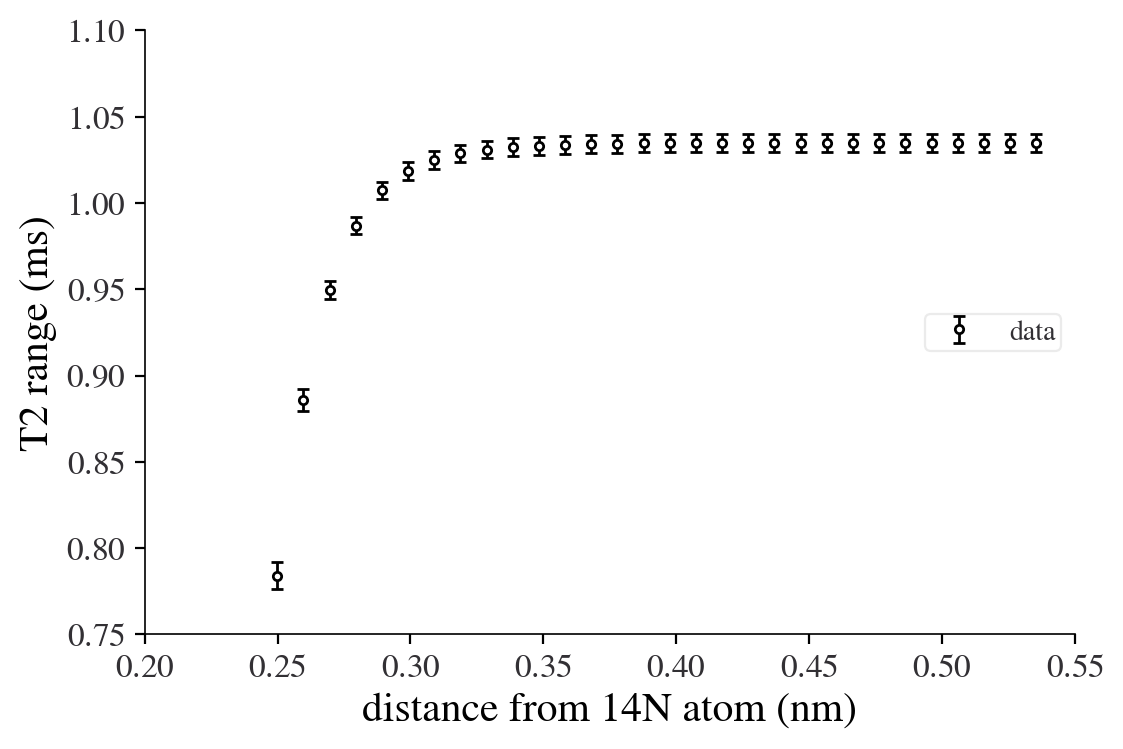

In [83]:

def position_fit(x,a,b,c,d,e):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = a - abs(b)/((c*x*3.57+d)**2+e)
    
    return fit

# def position_fit(x,a,b,c):
#     "fit coherence function to a negative squared exponential function with time constant T2"
    
#     fit = abs(a)*( (b/(x*3.57))**12 - 2*(b/(x*3.57))**6 ) + c
    
#     return fit

popt,pcov = curve_fit(position_fit, distances_far, T2_range_dist_far)

print(popt)

plt.figure()
plt.errorbar(distances_far*0.357, T2_range_dist_far, yerr=T2_range_dist_far_err, fmt='.', color='w', ecolor='k', elinewidth=1, capsize=2, label='data')
distances_fit = np.linspace(0.5,1.5, 100)
# plt.plot(distances_fit, position_fit(distances_fit,popt[0],popt[1],popt[2],popt[3],popt[4]), '-', label='best fit line')
plt.ylabel('T2 range (ms)',size=15)
plt.xlabel('distance from 14N atom (nm)',size=15)
plt.legend(loc='right')
#plt.title("T2 distribution for varying distance between a lone 14N and NV")

plt.savefig("T2distribution_14Nvarieddistance_fixedseed.png")


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


[ 1.0373943754  0.0080422052  1.1232043303 -2.7703719366  0.0304679023]


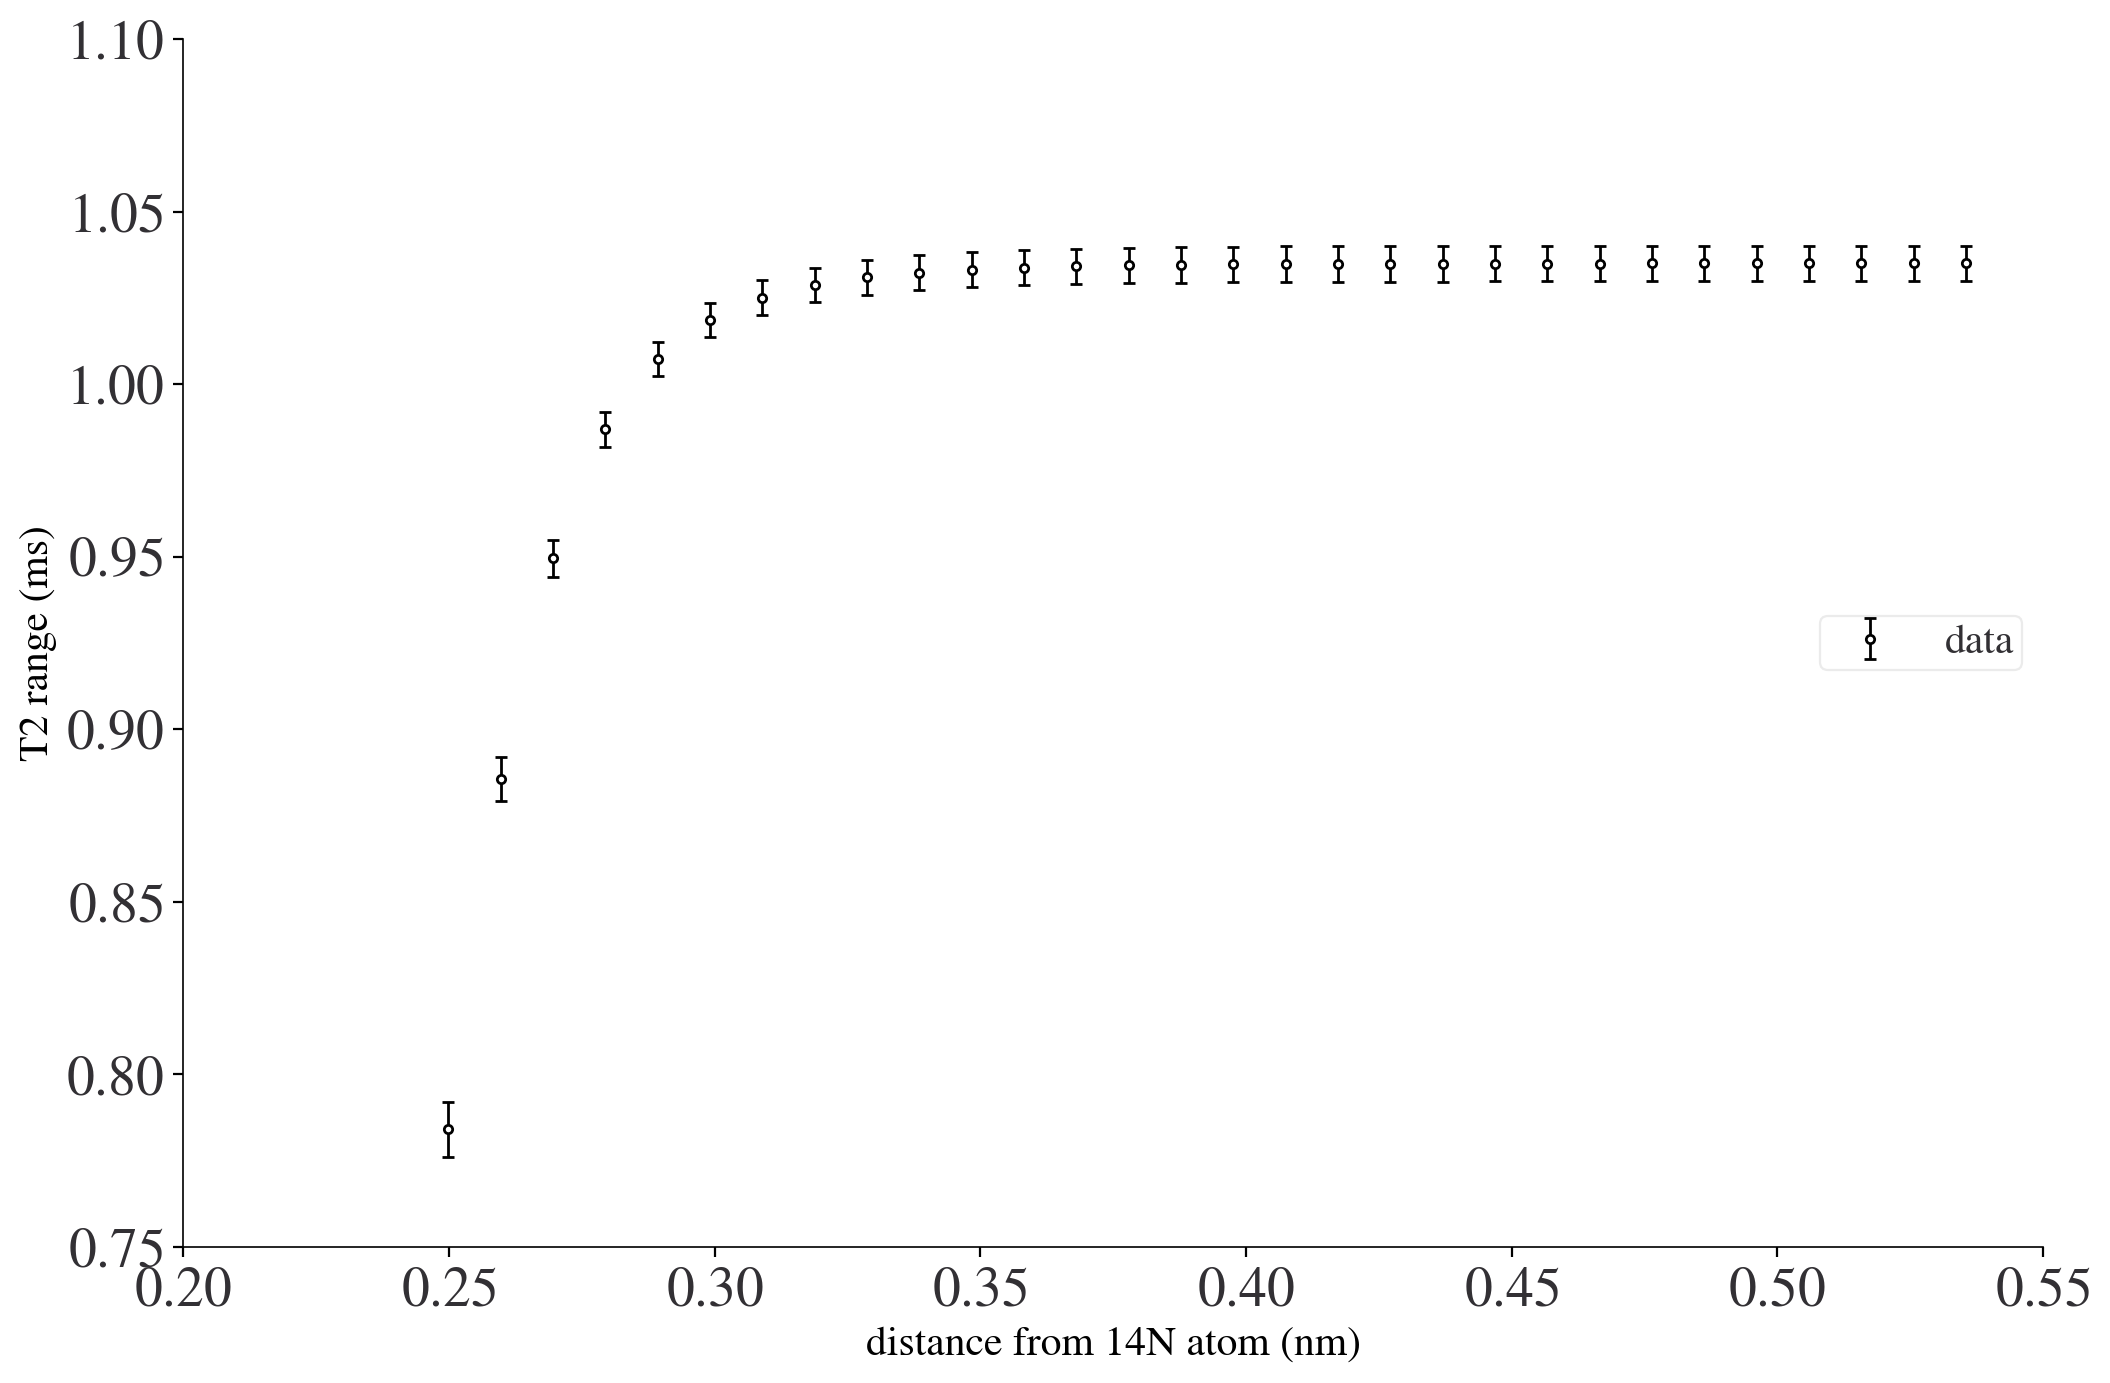

In [101]:
import matplotlib as mpl  
plt.style.use('plot_style.txt')
# mpl.rcParams['figure.figsize'] = [12.0, 8.0]
# mpl.rcParams['xtick.labelsize'] = 15

def position_fit(x,a,b,c,d,e):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = a - abs(b)/((c*x*3.57+d)**2+e)
    
    return fit

# def position_fit(x,a,b,c):
#     "fit coherence function to a negative squared exponential function with time constant T2"
    
#     fit = abs(a)*( (b/(x*3.57))**12 - 2*(b/(x*3.57))**6 ) + c
    
#     return fit

popt,pcov = curve_fit(position_fit, distances_far, T2_range_dist_far)

print(popt)

plt.figure()
plt.errorbar(distances_far*0.357, T2_range_dist_far, yerr=T2_range_dist_far_err, fmt='.', color='w', ecolor='k', elinewidth=1, capsize=2, label='data')
distances_fit = np.linspace(0.5,1.5, 100)
# plt.plot(distances_fit, position_fit(distances_fit,popt[0],popt[1],popt[2],popt[3],popt[4]), '-', label='best fit line')
plt.ylabel('T2 range (ms)',size=15)
plt.xlabel('distance from 14N atom (nm)',size=15)
plt.legend(loc='right')
#plt.title("T2 distribution for varying distance between a lone 14N and NV")

plt.savefig("T2distribution_14Nvarieddistance_fixedseed.png")

In [126]:

print(pc.common_isotopes['15N'])
print(pc.common_concentrations)

15N: (0.5, -2.7126)
{'Ag': {'107Ag': 0.51839, '109Ag': 0.48161000000000004}, 'Al': {'27Al': 1.0}, 'As': {'75As': 1.0}, 'Au': {'197Au': 1.0}, 'B': {'10B': 0.19899999999999998, '11B': 0.8009999999999999}, 'Ba': {'135Ba': 0.06591999999999999, '137Ba': 0.11231999999999999}, 'Be': {'9Be': 1.0}, 'Bi': {'209Bi': 1.0}, 'Br': {'79Br': 0.5069, '81Br': 0.49310000000000004}, 'C': {'13C': 0.010700000000000001}, 'Ca': {'43Ca': 0.00135}, 'Cd': {'111Cd': 0.128, '113Cd': 0.1222}, 'Cl': {'35Cl': 0.7578, '37Cl': 0.2422}, 'Co': {'59Co': 1.0}, 'Cr': {'53Cr': 0.09501}, 'Cs': {'133Cs': 1.0}, 'Cu': {'63Cu': 0.6917, '65Cu': 0.30829999999999996}, 'Dy': {'161Dy': 0.1891, '163Dy': 0.249}, 'Er': {'167Er': 0.2293}, 'Eu': {'151Eu': 0.4781, '153Eu': 0.5219}, 'F': {'19F': 1.0}, 'Fe': {'57Fe': 0.02119}, 'Ga': {'69Ga': 0.60108, '71Ga': 0.39892000000000005}, 'Gd': {'155Gd': 0.14800000000000002, '157Gd': 0.1565}, 'Ge': {'73Ge': 0.07730000000000001}, 'H': {'1H': 0.999885, '2H': 0.000115}, 'He': {'3He': 1.37e-06}, 'Hf': {'1

[('14N', [ 0.     ,  0.     ,  3.09171], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.64891, -1.64891,  4.74062], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.71142, -1.35442,  4.9338 ], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.74744, -1.03344,  5.10049], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.75491, -0.68391,  5.23864], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.72977, -0.30177,  5.34417], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.6644 ,  0.1206 ,  5.40946], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.54331,  0.59869,  5.41905], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.

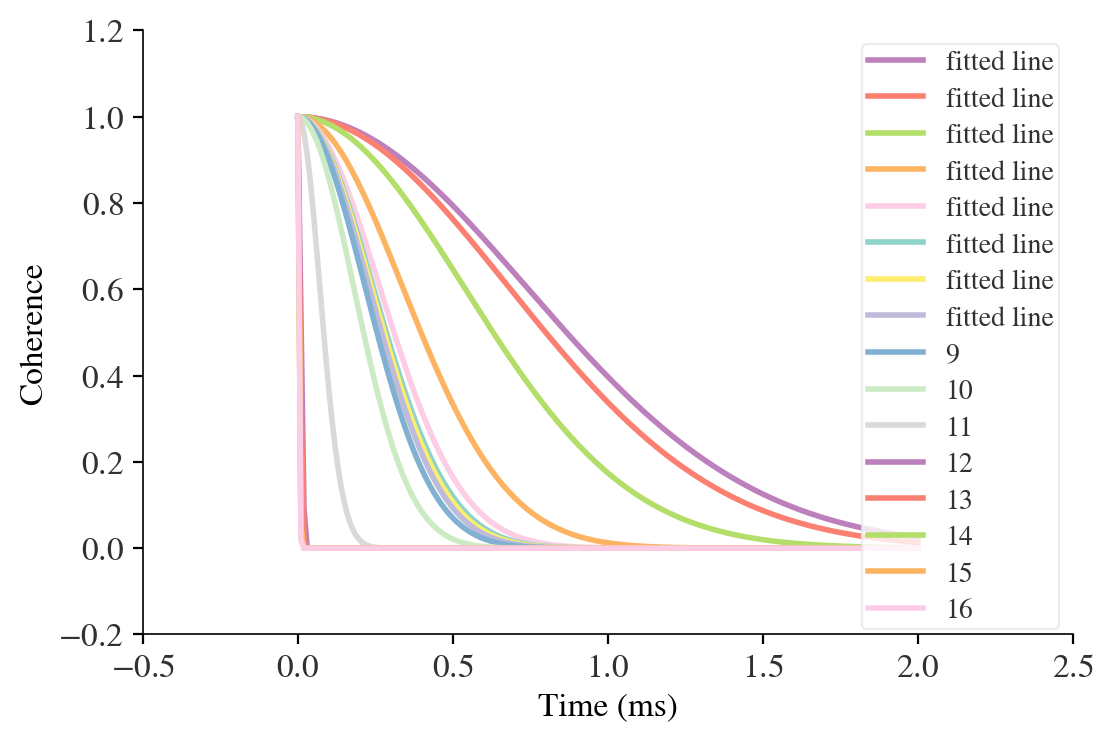

In [189]:
""" random positions in right quadrants """
""" inefficient assignment of impurities """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit


repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Number of random bath states to sample over
n_bath_states = 20

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


T2_range_08 = []
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
time_space = np.linspace(0, 2, 201)  # in ms
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_1 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_1.real)
T2_range_08.append(popt)

y_samp_1 = coherence_fit(time_space, popt)
plt.plot(time_space, y_samp_1,'-', label='fitted line')

# plt.plot(time_space, l_gcce_1.real,
#          label='coherence decay', ls='', marker='.')


#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_2 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_2.real)
T2_range_08.append(popt)

y_samp_2 = coherence_fit(time_space, popt)
plt.plot(time_space, y_samp_2,'-', label='fitted line')

# plt.plot(time_space, l_gcce_2.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_3 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_3.real)
T2_range_08.append(popt)

y_samp_3 = coherence_fit(time_space, popt)
plt.plot(time_space, y_samp_3,'-', label='fitted line')

# plt.plot(time_space, l_gcce_3.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_4 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_4.real)
T2_range_08.append(popt)

y_samp_4 = coherence_fit(time_space, popt)
plt.plot(time_space, y_samp_4,'-', label='fitted line')

# plt.plot(time_space, l_gcce_4.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_5 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_5.real)
T2_range_08.append(popt)

y_samp_5 = coherence_fit(time_space, popt)
plt.plot(time_space, y_samp_5,'-', label='fitted line')

# plt.plot(time_space, l_gcce_5.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_6 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_6.real)
T2_range_08.append(popt)

y_samp_6 = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp_6,'-', label='fitted line')

# plt.plot(time_space, l_gcce_6.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_7 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_7.real)
T2_range_08.append(popt)

y_samp_7 = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp_7,'-', label='fitted line')

# plt.plot(time_space, l_gcce_7.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce_8 = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce_8.real)
T2_range_08.append(popt)

y_samp_8 = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp_8,'-', label='fitted line')

# plt.plot(time_space, l_gcce_8.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='9')

# plt.plot(time_space, l_gcce.real,
#          label='9', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.1127016654])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='10')

# plt.plot(time_space, l_gcce.real,
#          label='10', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.1, -0.02915026221])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='11')

# plt.plot(time_space, l_gcce.real,
#          label='11', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1, -0.1244997998])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='12')

# plt.plot(time_space, l_gcce.real,
#          label='12', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 0.9, -0.192820323])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=20,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='13')

# plt.plot(time_space, l_gcce.real,
#          label='13', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 0.9, -0.192820323]),
                                       ('14N',  [0.5, 0.8, -0.2416198487])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=20,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='14')

# plt.plot(time_space, l_gcce.real,
#          label='14', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 0.9, -0.192820323]),
                                       ('14N',  [0.5, 0.8, -0.2416198487]),('14N',  [0.5, 0.7, -0.2745966692])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=20,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='15')

# plt.plot(time_space, l_gcce.real,
#          label='15', ls='', marker='.')

#########################################################################
#########################################################################
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.3]),
                                       ('14N',  [0.5, 0.6, 1.293725393]),('14N',  [0.5, 0.7, 1.27459669]),
                                       ('14N',  [0.5, 0.8, 1.241619849]),('14N',  [0.5, 0.9, 1.192820323]),
                                       ('14N',  [0.5, 1, 1.1244998]),('14N',  [0.5, 1.1, 1.029150262]),
                                       ('14N',  [0.5, 1.2, 0.8872983346]),('14N',  [0.5, 1.3, 0.5]),
                                       ('14N',  [0.5, 1.2, 0.1127016654]),('14N',  [0.5, 1.1, -0.02915026221]),
                                       ('14N',  [0.5, 1, -0.1244997998]),('14N',  [0.5, 0.9, -0.192820323]),
                                       ('14N',  [0.5, 0.8, -0.2416198487]),('14N',  [0.5, 0.7, -0.2745966692]),
                                       ('14N',  [0.5, 0.6, -0.2937253933])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=30,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_08.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='16')

# plt.plot(time_space, l_gcce.real,
#          label='16', ls='', marker='.')


#########################################################################


print(atoms['14N'])

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("14Ncoherencedecay_2.856angs.png")

[array([1.07025]), array([0.96703]), array([0.75546]), array([0.6627]), array([0.61916]), array([0.61048]), array([0.60363]), array([0.59668]), array([0.58632]), array([0.565]), array([0.49615]), array([0.39072]), array([0.291]), array([0.22466]), array([0.19132]), array([0.18466])]


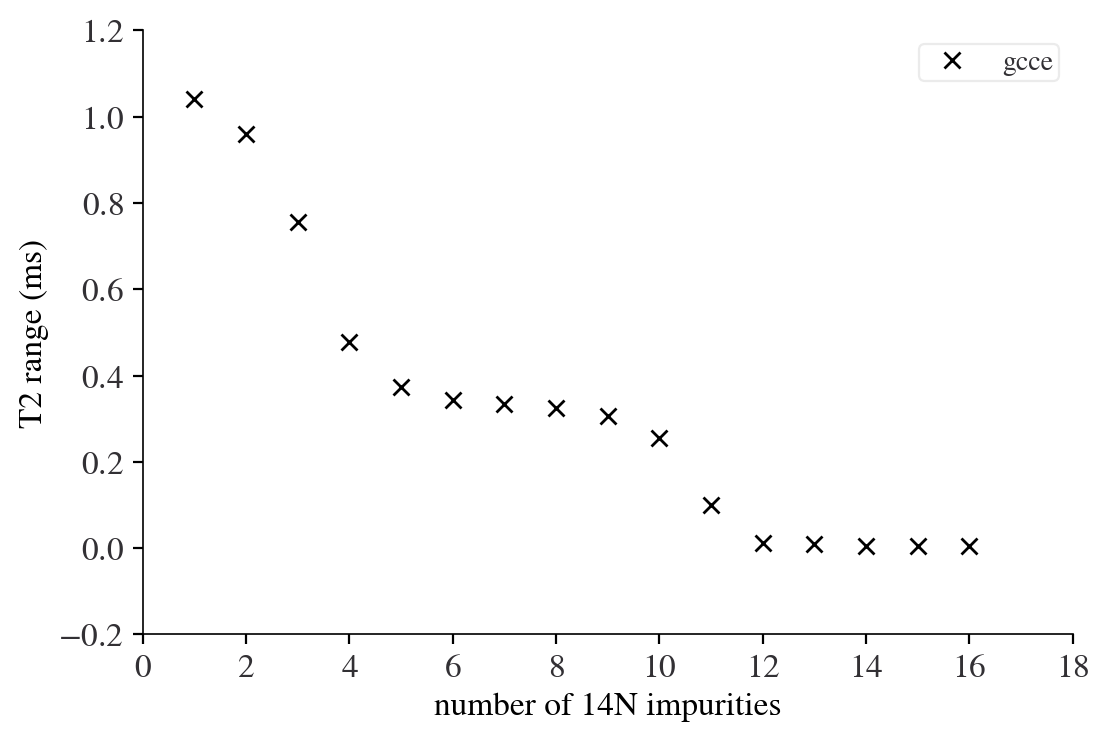

In [190]:
number = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
print(T2_range)
plt.figure()
plt.plot(number, T2_range_08, 'rx', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
plt.legend()
# plt.title("T2 distribution for varying number of 14N impurities at 0.8 angstrom from NV center")

plt.savefig("T2distribution_14N_0.8angs_16impure_fixedseed.png")

[('14N', [ 0.     ,  0.     ,  3.09171], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.85503, -1.85503,  4.94674], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.9181 , -1.5611 ,  5.14048], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.95851, -1.24451,  5.31156], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.97624, -0.90524,  5.45996], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.96305, -0.53505,  5.57745], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.91895, -0.13395,  5.66401], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-1.83568,  0.30632,  5.71142], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.

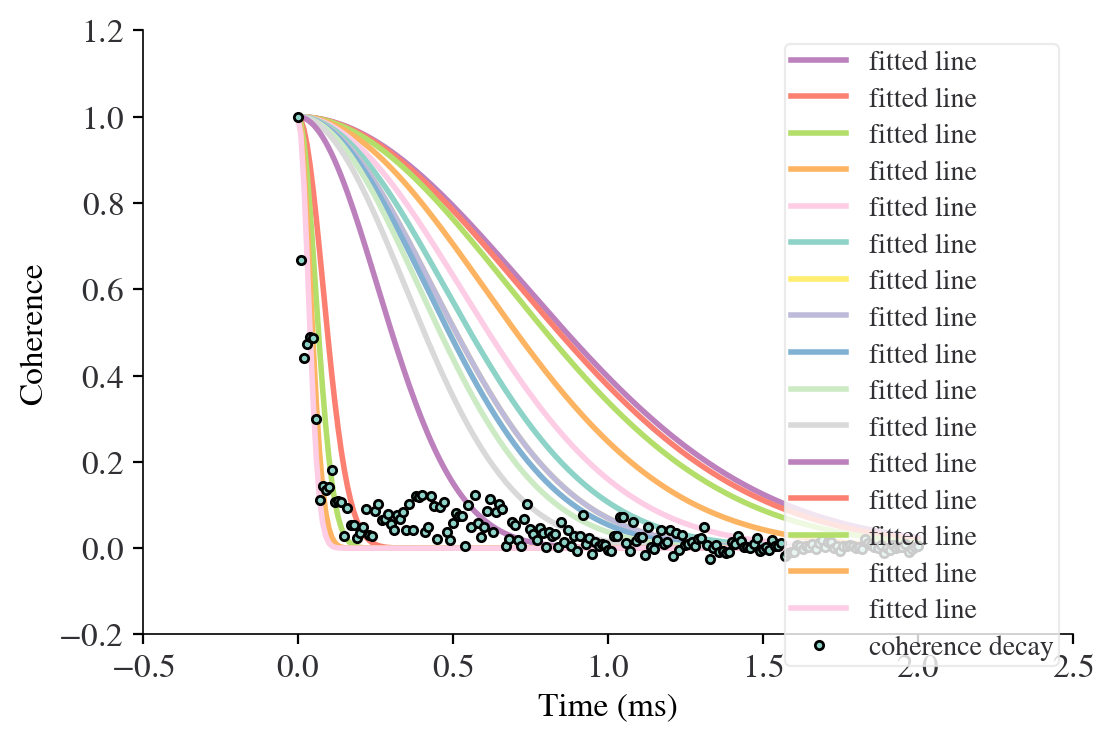

In [248]:
""" random positions in right quadrants """
""" inefficient assignment of impurities at 0.9*3.57 angstrom"""

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit


repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Number of random bath states to sample over
n_bath_states = 20

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


T2_range_09 = []
diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001



#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657]),('14N',  [0.5, 1.3, 0.9123])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657]),('14N',  [0.5, 1.3, 0.9123]),
                                       ('14N',  [0.5, 1.4, 0.5])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657]),('14N',  [0.5, 1.3, 0.9123]),
                                       ('14N',  [0.5, 1.4, 0.5]),('14N',  [0.5, 1.3, 0.0877])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657]),('14N',  [0.5, 1.3, 0.9123]),
                                       ('14N',  [0.5, 1.4, 0.5]),('14N',  [0.5, 1.3, 0.0877]),
                                       ('14N',  [0.5, 1.2, -0.0657])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657]),('14N',  [0.5, 1.3, 0.9123]),
                                       ('14N',  [0.5, 1.4, 0.5]),('14N',  [0.5, 1.3, 0.0877]),
                                       ('14N',  [0.5, 1.2, -0.0657]),('14N',  [0.5, 1.1, -0.1708])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657]),('14N',  [0.5, 1.3, 0.9123]),
                                       ('14N',  [0.5, 1.4, 0.5]),('14N',  [0.5, 1.3, 0.0877]),
                                       ('14N',  [0.5, 1.2, -0.0657]),('14N',  [0.5, 1.1, -0.1708]),
                                       ('14N',  [0.5, 1, -0.2483])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=50,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
# plt.plot(time_space, l_gcce.real,
#          label='coherence decay', ls='', marker='.')

#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.4]),
                                       ('14N',  [0.5, 0.6, 1.394]),('14N',  [0.5, 0.7, 1.377]),
                                       ('14N',  [0.5, 0.8, 1.349]),('14N',  [0.5, 0.9, 1.306]),
                                       ('14N',  [0.5, 1, 1.248]),('14N',  [0.5, 1.1, 1.171]),
                                       ('14N',  [0.5, 1.2, 1.0657]),('14N',  [0.5, 1.3, 0.9123]),
                                       ('14N',  [0.5, 1.4, 0.5]),('14N',  [0.5, 1.3, 0.0877]),
                                       ('14N',  [0.5, 1.2, -0.0657]),('14N',  [0.5, 1.1, -0.1708]),
                                       ('14N',  [0.5, 1, -0.2483]),('14N',  [0.5, 0.9, 0.3062])],
                             seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,nbstates=50,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_09.append(popt)

y_samp = coherence_fit(time_space, popt)
plt.plot(time_space,y_samp,'-', label='fitted line')
plt.plot(time_space, l_gcce.real,
         label='coherence decay', ls='', marker='.')

#########################################################################



print(atoms['14N'])


plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
#plt.title("fitted line to the calculated coherence decay")

plt.savefig("coherence_decays_3.213angs.png")

[array([1.04035]), array([1.01228]), array([0.96206]), array([0.8461]), array([0.73872]), array([0.66853]), array([0.61315]), array([0.61315]), array([0.58608]), array([0.55167]), array([0.48968]), array([0.36387]), array([0.11484]), array([0.08015]), array([0.05714]), array([0.0476])]


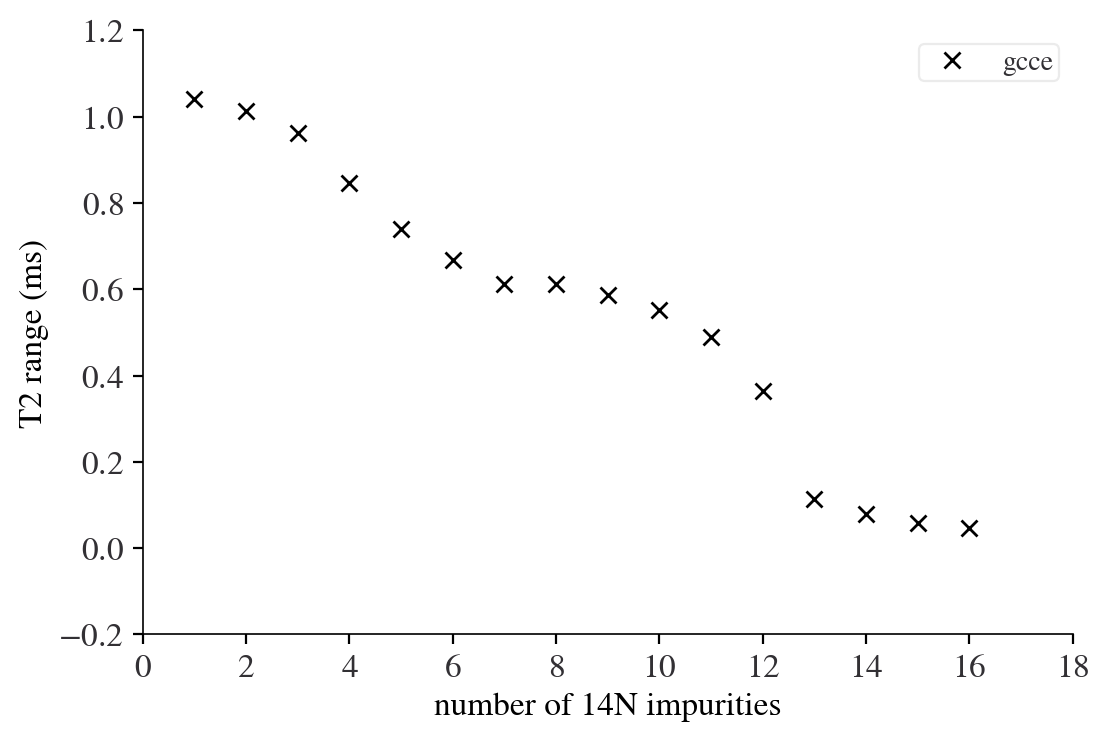

In [250]:
number = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
print(T2_range_09)
plt.figure()
plt.plot(number, T2_range_09, 'rx', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
# plt.yscale("log")
plt.legend()
# plt.title("T2 distribution for varying number of 14N impurities at 0.8 angstrom from NV center")

plt.savefig("T2distribution_14N_0.9angs_16impure_fixedseed.png")

In [194]:
""" inefficient assignment of impurities """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit


repeats = 100
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]


# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 6  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

diamond.add_isotopes(('13C', 0.011))
diamond.isotopes['C']['14C'] = 0.001

T2_range_sqrt2 = []
T2_var = []

#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3]),
                                       ('14N',  [0.5, 1.7, -0.248])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3]),
                                       ('14N',  [0.5, 1.7, -0.248]),('14N',  [0.5, 1.5, -0.5])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3]),
                                       ('14N',  [0.5, 1.7, -0.248]),('14N',  [0.5, 1.5, -0.5]),
                                       ('14N',  [0.5, 1.3, -0.666])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3]),
                                       ('14N',  [0.5, 1.7, -0.248]),('14N',  [0.5, 1.5, -0.5]),
                                       ('14N',  [0.5, 1.3, -0.666]),('14N',  [0.5, 1.1, -0.781])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3]),
                                       ('14N',  [0.5, 1.7, -0.248]),('14N',  [0.5, 1.5, -0.5]),
                                       ('14N',  [0.5, 1.3, -0.666]),('14N',  [0.5, 1.1, -0.781]),
                                       ('14N',  [0.5, 0.9, -0.856])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3]),
                                       ('14N',  [0.5, 1.7, -0.248]),('14N',  [0.5, 1.5, -0.5]),
                                       ('14N',  [0.5, 1.3, -0.666]),('14N',  [0.5, 1.1, -0.781]),
                                       ('14N',  [0.5, 0.9, -0.856]),('14N',  [0.5, 0.7, -0.9])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################
#########################################################################

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5]),('14N',  [0.5, 0.5, 1.914]),
                                       ('14N',  [0.5, 0.7, 1.9]),('14N',  [0.5, 0.9, 1.856]),
                                       ('14N',  [0.5, 1.1, 1.781]),('14N',  [0.5, 1.3, 1.666]),
                                       ('14N',  [0.5, 1.5, 1.5]),('14N',  [0.5, 1.7, 1.248]),
                                       ('14N',  [0.5, 1.9, 0.7]),('14N',  [0.5, 1.9, 0.3]),
                                       ('14N',  [0.5, 1.7, -0.248]),('14N',  [0.5, 1.5, -0.5]),
                                       ('14N',  [0.5, 1.3, -0.666]),('14N',  [0.5, 1.1, -0.781]),
                                       ('14N',  [0.5, 0.9, -0.856]),('14N',  [0.5, 0.7, -0.9]),
                                       ('14N',  [0.5, 0.5, -0.914])], seed=seed)
atoms['14C'].gyro = 0
atoms['14C'].spin = 0
calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
T2_range_sqrt2.append(popt)
T2_var.append(pcov)
#########################################################################




print(atoms['14N'])
print(T2_range_sqrt2)


[('14N', [ 0.     ,  0.     ,  3.09171], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-2.91445, -2.91445,  6.00616], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-3.03648, -2.32248,  6.38954], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-3.09668, -1.66868,  6.71107], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-3.09298, -0.95098,  6.96872], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-3.00683, -0.15083,  7.14391], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-2.81557,  0.75443,  7.21399], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
 ('14N', [-2.44705,  1.83695,  7.10681], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.

[array([[0.00004]]), array([[0.00003]]), array([[0.00003]]), array([[0.00003]]), array([[0.00003]]), array([[0.00003]]), array([[0.00003]]), array([[0.00003]]), array([[0.00004]]), array([[0.00007]]), array([[0.00012]]), array([[0.00012]]), array([[0.0001]]), array([[0.00009]]), array([[0.00008]]), array([[0.00008]])]


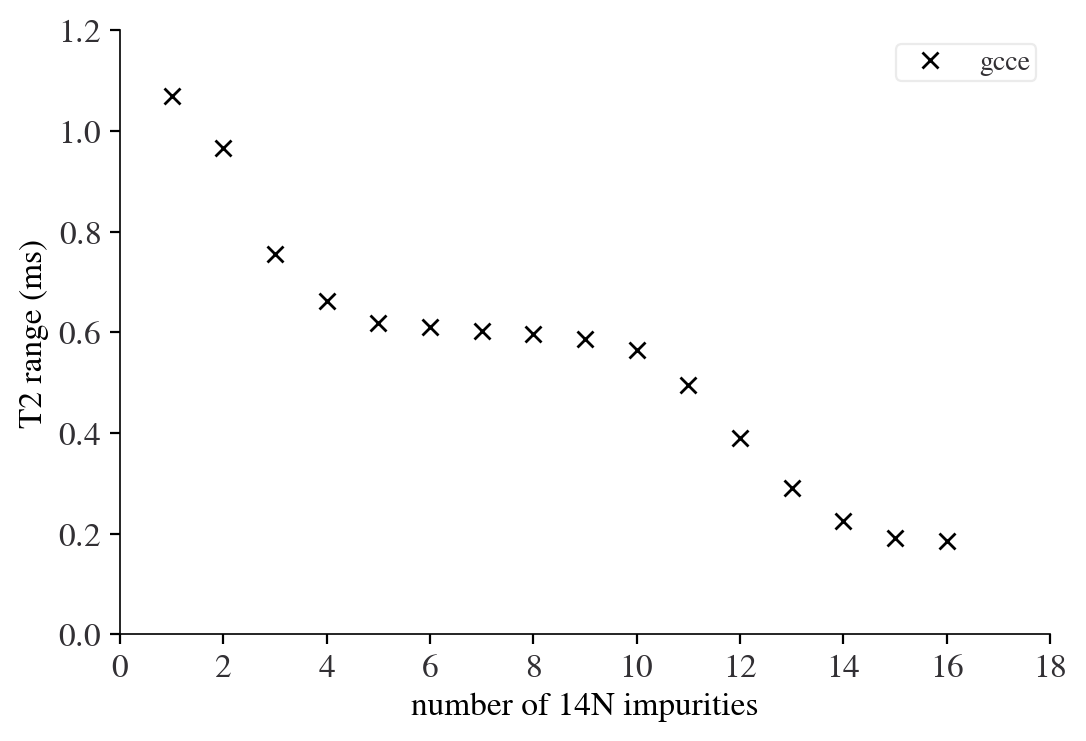

In [195]:
number = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
print(T2_var)

plt.figure()
plt.plot(number, T2_range_sqrt2, 'x', label='gcce')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
# plt.yscale('log')
plt.legend()
#plt.title("T2 distribution for varying number of 14N impurities at sqrt(2) or 1.414 angstrom from NV center")
plt.savefig("T2distribution_14N_sqrt2angs_16impure_fixedseed.png")

In [92]:
number = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])


plt.figure()
plt.plot(number, T2_range_08, '.-', label='2.856 $\AA$')
plt.plot(number, T2_range_09, 'o-', label='3.213 $\AA$')
plt.plot(number, T2_range_sqrt2, 'x-', label='5.049 $\AA$')
plt.ylabel('T2 range (ms)')
plt.xlabel('number of 14N impurities')
# plt.yscale('log')
plt.legend()
#plt.title("T2 distribution for varying number of 14N impurities at sqrt(2) or 1.414 angstrom from NV center")
plt.savefig("T2distribution_14N_16impure_fixedseed.png")

NameError: name 'T2_range_08' is not defined

<Figure size 1200x800 with 0 Axes>

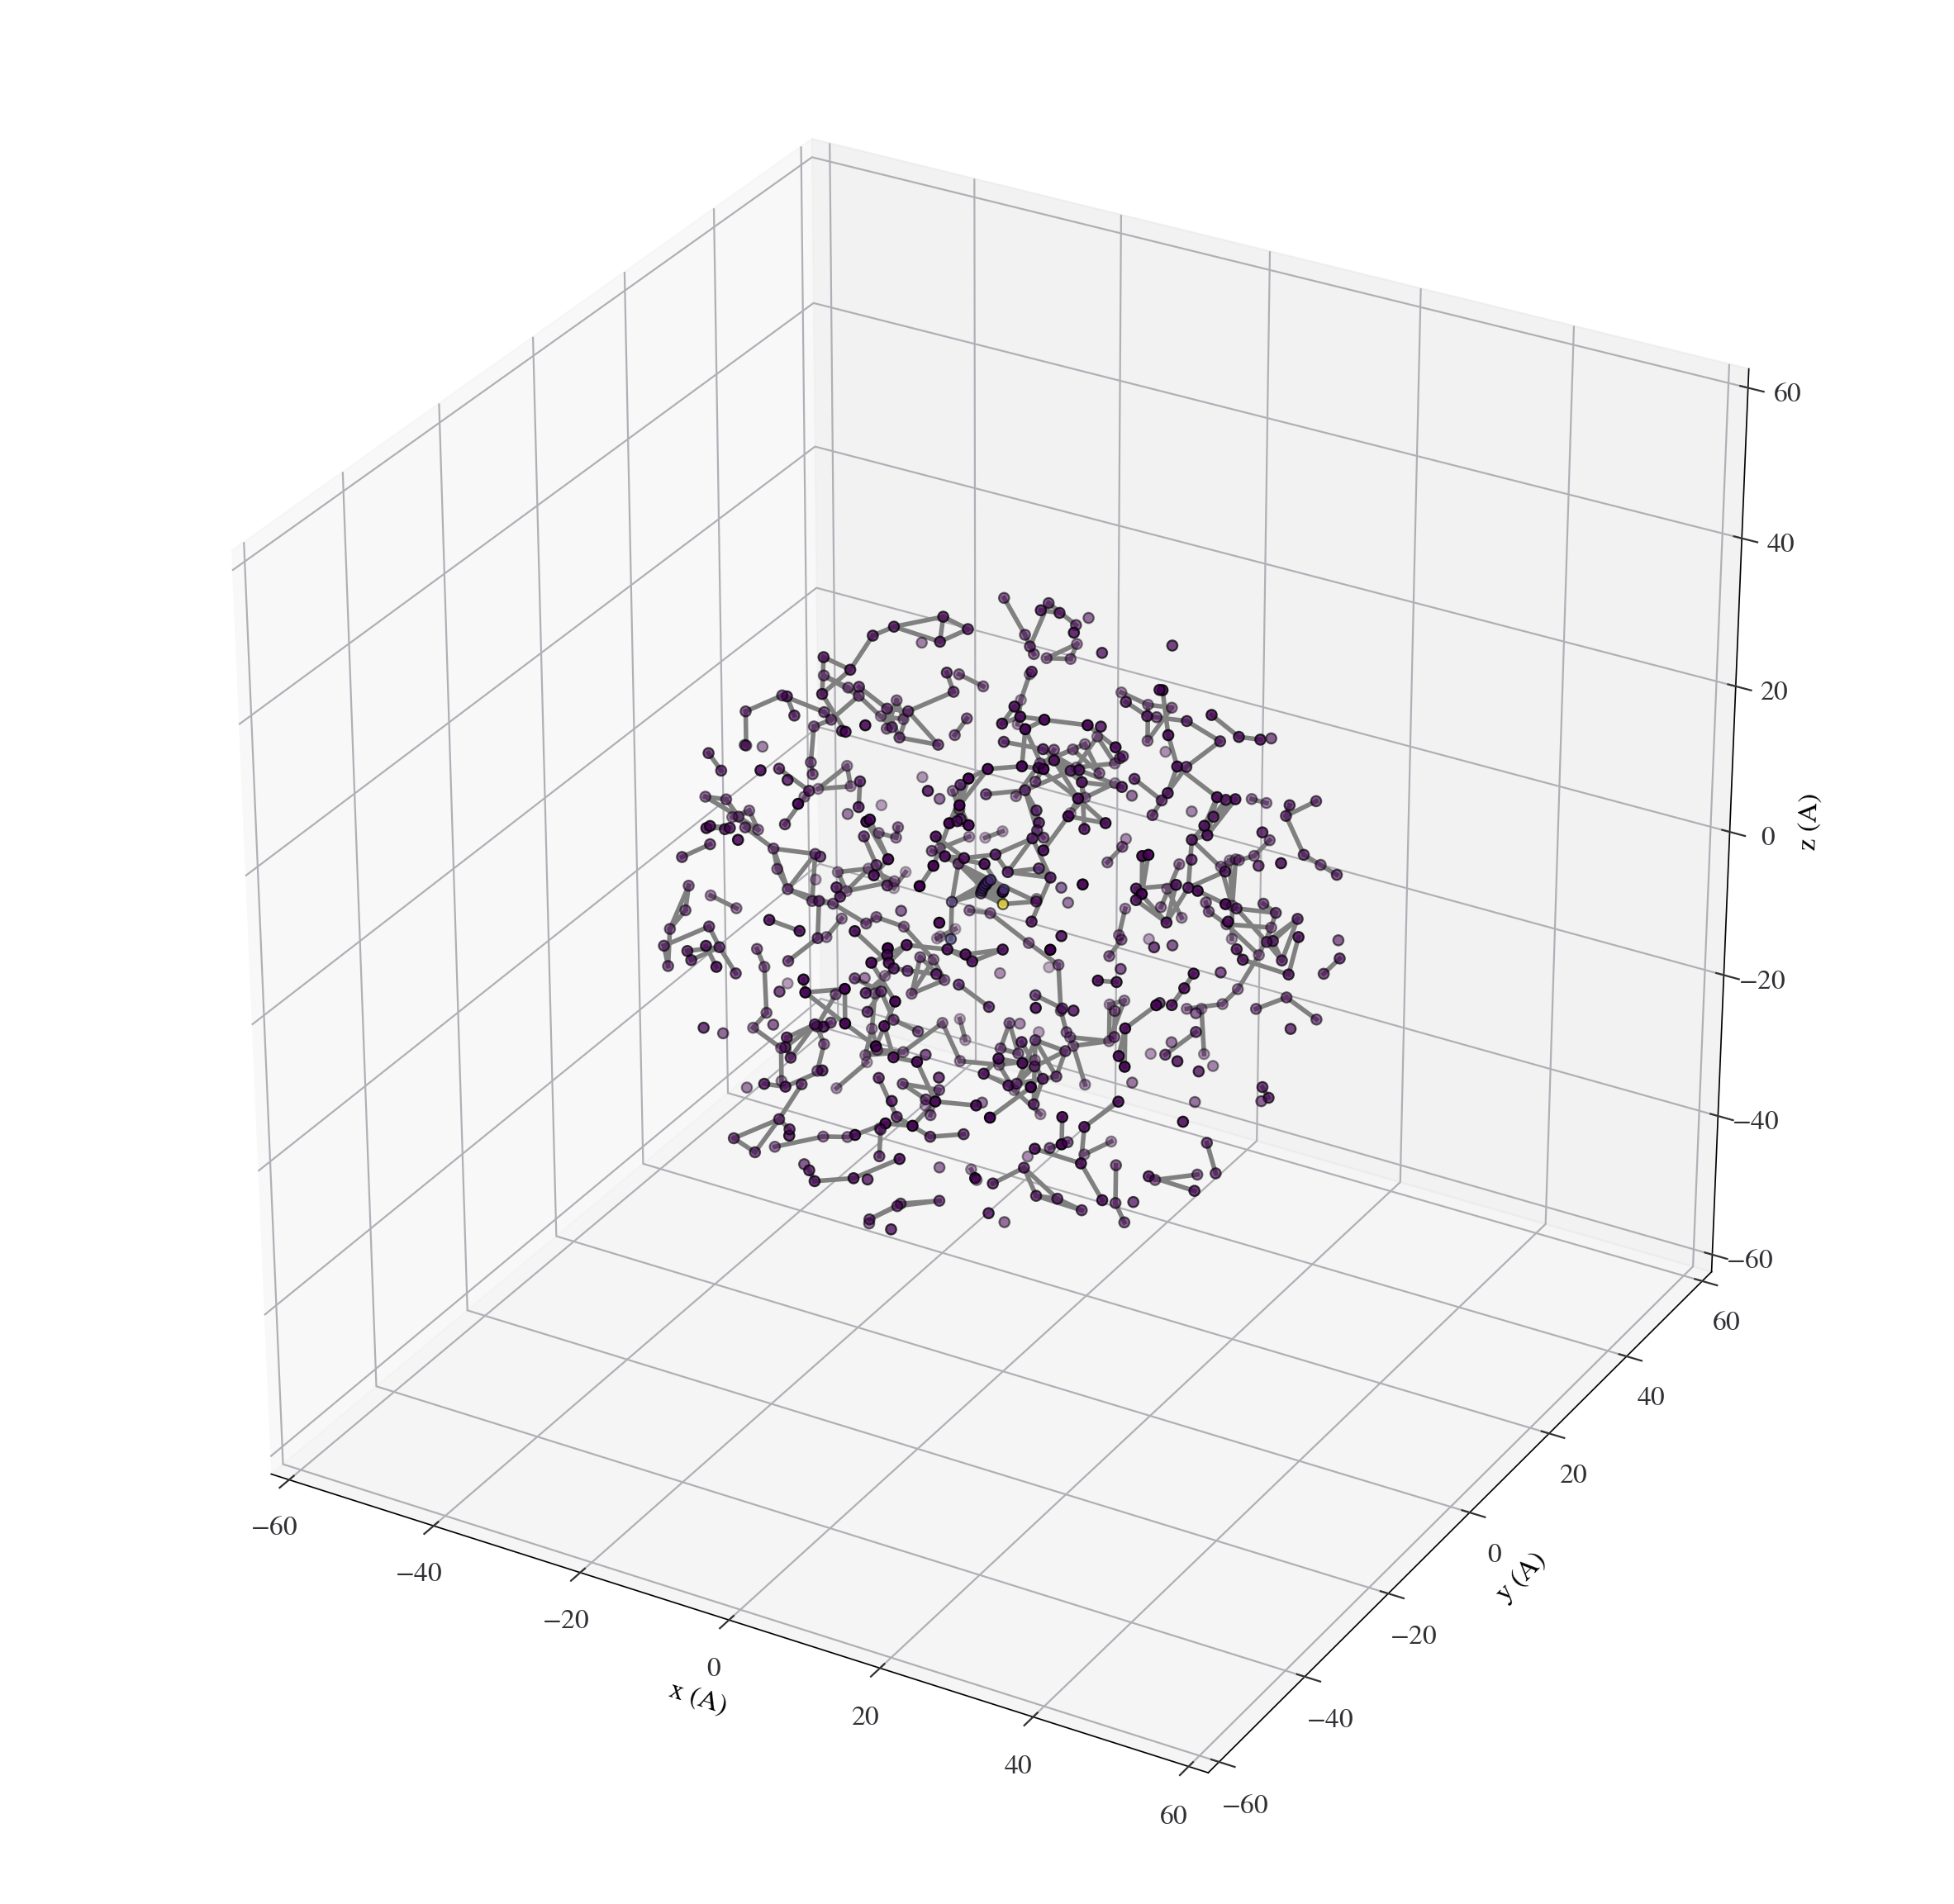

In [16]:
# add 3D axis
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

# We want to visualize the smaller bath
data = calc.bath

# First plot the positions of the bath
colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# Plot all pairs of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 2
for c in calc.clusters[2]:
    ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# Plot all triplets of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 3
# for c in mock.clusters[3]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');

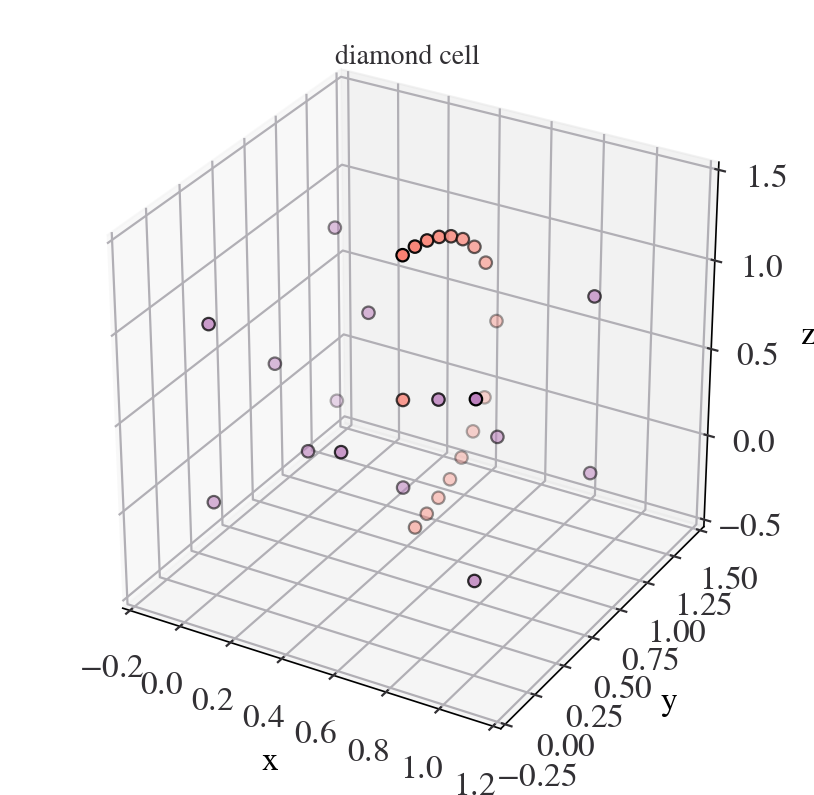

In [55]:

# add 3D axis
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

# set coordinate points of lattice
x = np.array([0, 0.25, 0  , 0.25, 0.5, 0.75, 0.5, 0.75, 1, 0, 0, 1, 0, 1, 1, ])
y = np.array([0, 0.25, 0.5, 0.75, 0  , 0.25, 0.5, 0.75, 1, 0, 1, 0, 1, 0, 1, ])
z = np.array([0, 0.25, 0.5, 0.75, 0.5, 0.75, 0  , 0.25, 1, 1, 0, 0, 1, 1, 0, ])


x1 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
y1 = np.array([0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6])
z1 = np.array([0.5, 1.3, 1.293725393, 1.27459669, 1.241619849, 1.192820323, 1.1244998, 1.029150262, 0.8872983346, 0.5,
              0.1127016654, -0.02915026221, -0.1244997998, -0.192820323, -0.2416198487, -0.2745966692, -0.2937253933])

# plotting
ax.scatter3D(x, y, z, 'o')
ax.scatter3D(x1, y1, z1, 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('diamond cell')
plt.show()

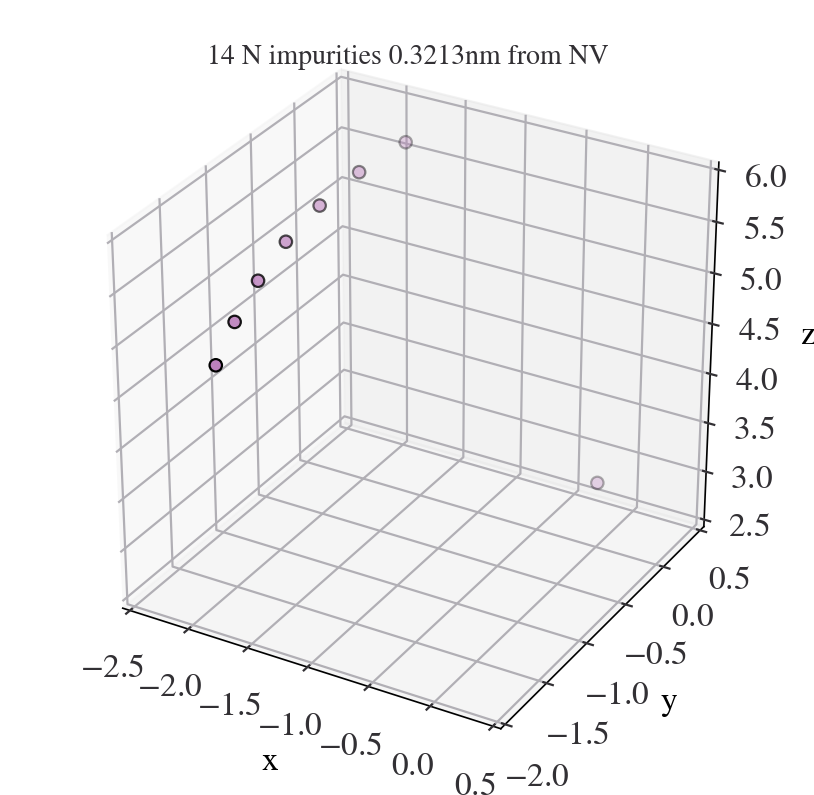

In [56]:

# add 3D axis
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')


# set coordinate points of lattice
x1 = np.array([0      , -1.85503, -1.9181 , -1.95851, -1.97624, -1.96305, -1.91895, -1.83568 ])
y1 = np.array([0      , -1.85503, -1.5611 , -1.24451, -0.90524, -0.53505, -0.13395,  0.30632 ])
z1 = np.array([3.09171,  4.94674,  5.14048,  5.31156,  5.45996,  5.57745,  5.66401,  5.71142 ])

# plotting
ax.scatter3D(x1, y1, z1, 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('14 N impurities 0.3213nm from NV')
plt.show()

In [6]:
""" pseudo varied 14N impurity concentration """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit

repeats = 30
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase



# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 200  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

bathsize = 1000

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

p1 = pc.Pulse('x', np.pi)
p2 = pc.Pulse('y', np.pi)
seq = [p1, p2, p1, p2]

concentration = np.linspace(0.0008, 0.08, repeats)

# T2_range_XY4 = []

# for i in concentration:
#     diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
#     diamond.zdir = [1,1,1]
#     diamond.add_isotopes(('13C', 0.011))
#     diamond.isotopes['C']['14C'] = 0.001
#     diamond.add_atoms(('N', [0.5, 0.5, 1]), type="cell")
#     diamond.add_isotopes(('14N', i))
#     atoms = diamond.gen_supercell(bathsize, remove=[('C', [0., 0, 0]),
#                                                ('C', [0.5, 0.5, 0.5])],
#                                   add=[('14N', [0.5, 0.5, 0.5])], seed=seed)
#     atoms['14C'].gyro = 0
#     atoms['14C'].spin = 0
#     calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
#     l_gcce = calc.compute(time_space, magnetic_field=b,
#                           pulses=seq,
#                           method='gcce', quantity='coherence')
#     popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
#     T2_range_XY4.append(popt)

T2_range_hahn = []
for i in concentration:
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    diamond.add_isotopes(('13C', 0.011))
    diamond.isotopes['C']['14C'] = 0.001
    diamond.add_atoms(('N', [0.5, 0.5, 1]), type="cell")
    diamond.add_isotopes(('14N', i))
    atoms = diamond.gen_supercell(bathsize, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5])], seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_range_hahn.append(popt)

# seq_8 = [p1, p2, p1, p2, p1, p2, p1, p2]
# T2_range_XY8 = []
# for i in concentration:
#     diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
#     diamond.zdir = [1,1,1]
#     diamond.add_isotopes(('13C', 0.011))
#     diamond.isotopes['C']['14C'] = 0.001
#     diamond.add_atoms(('N', [0.5, 0.5, 1]), type="cell")
#     diamond.add_isotopes(('14N', i))
#     atoms = diamond.gen_supercell(bathsize, remove=[('C', [0., 0, 0]),
#                                                ('C', [0.5, 0.5, 0.5])],
#                                   add=[('14N', [0.5, 0.5, 0.5])], seed=seed)
#     atoms['14C'].gyro = 0
#     atoms['14C'].spin = 0
#     calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
#     l_gcce = calc.compute(time_space, magnetic_field=b,
#                           pulses=seq_8,
#                           method='gcce', quantity='coherence')
#     popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
#     T2_range_XY8.append(popt)


T2_range_CPMG4 = []
for i in concentration:
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    diamond.add_isotopes(('13C', 0.011))
    diamond.isotopes['C']['14C'] = 0.001
    diamond.add_atoms(('N', [0.5, 0.5, 1]), type="cell")
    diamond.add_isotopes(('14N', i))
    atoms = diamond.gen_supercell(bathsize, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5])], seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=4,
                          method='gcce', quantity='coherence')
    popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
    T2_range_CPMG4.append(popt)
    
T2_range_CPMG8 = []
for i in concentration:
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    diamond.add_isotopes(('13C', 0.011))
    diamond.isotopes['C']['14C'] = 0.001
    diamond.add_atoms(('N', [0.5, 0.5, 1]), type="cell")
    diamond.add_isotopes(('14N', i))
    atoms = diamond.gen_supercell(bathsize, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5])], seed=seed)
    atoms['14C'].gyro = 0
    atoms['14C'].spin = 0
    calc = pc.Simulator(spin=nv, bath=atoms, r_bath=r_bath, r_dipole=r_dipole, order=order)
    l_gcce = calc.compute(time_space, magnetic_field=b,
                          pulses=8,
                          method='gcce', quantity='coherence')
    popt,pcov = curve_fit(coherence_fit,time_space, l_gcce.real)
    T2_range_CPMG8.append(popt)


KeyboardInterrupt: 

In [70]:
for i in range(repeats):
    if T2_range_XY4[i] < 0.1 :
        print(i)
        
print()

for i in range(repeats):
    if T2_range_XY8[i] < 0.1 :
        print(i)
        
        
print()

for i in range(repeats):
    if T2_range_hahn[i] < 0.1 :
        print(i)

        
print()

for i in range(repeats):
    if T2_range_CPMG4[i] < 0.1 :
        print(i)
        
        
print()

for i in range(repeats):
    if T2_range_CPMG8[i] < 0.1 :
        print(i)

13
17

13
17

13

13
17

13
17


In [ ]:
# T2_range_XY4_cleaned = np.delete(T2_range_XY4, [13,17])
# T2_range_XY8_cleaned = np.delete(T2_range_XY8, [13,17])
# T2_range_hahn_cleaned = np.delete(T2_range_hahn, [13])
# T2_range_CPMG4_cleaned = np.delete(T2_range_CPMG4, [13,17])
# T2_range_CPMG8_cleaned = np.delete(T2_range_CPMG8, [13,17])
# concentration_cleaned_hahn = np.delete(concentration, [13])
# concentration_cleaned = np.delete(concentration, [13,17])

plt.figure()
plt.plot(concentration/8, T2_range_hahn, label='Hahn Echo')
plt.plot(concentration/8, T2_range_CPMG4,  label='CPMG-4')
plt.plot(concentration/8, T2_range_CPMG8,  label='CPMG-8')
# plt.plot(concentration/8, T2_range_XY4, 'x', label='XY-4')
# plt.plot(concentration/8, T2_range_XY8, '.', label='XY-8')
# plt.plot(concentration_cleaned/8, T2_range_XY4_cleaned,  label='XY-4')
# plt.plot(concentration_cleaned/8, T2_range_XY8_cleaned,  label='XY-8')
# plt.plot(concentration_cleaned_hahn/8, T2_range_hahn_cleaned,  label='Hahn Echo')
# plt.plot(concentration_cleaned/8, T2_range_CPMG4_cleaned, label='CPMG-4')
# plt.plot(concentration_cleaned/8, T2_range_CPMG8_cleaned, label='CPMG-8')
plt.ylabel('T2 range (ms)')
plt.xlabel('14N impurity concentration(%)')
plt.yscale("log")
plt.xscale("log")
plt.legend(loc='lower left')
# plt.title("T2 distribution for varying concentration of 14N impurities")

In [129]:
print(T2_range)

[array([0.76259]), array([1.13827]), array([1.05424]), array([1.09711]), array([0.96036]), array([0.96036]), array([1.01352]), array([0.9634]), array([0.9634]), array([0.9634]), array([0.96512]), array([0.96512]), array([0.94978]), array([0.98691]), array([0.98691]), array([0.82438]), array([0.53396]), array([0.53396])]


In [ ]:
""" pseudo varied 14N impurity concentration """

def coherence_fit(x,T_2):
    "fit coherence function to a negative squared exponential function with time constant T2"
    
    fit = np.exp(-(x/T_2)**2)
    
    return fit


time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

# Generate unitcell from ase



# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 350  # in A
# Cluster cutoff radius
r_dipole = 50  # in A


# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]


concentration = np.linspace(1e17,1e20,20)
T2_random14N = []
T2_err_random14N

diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)


for i in concentration:
    nitrogen = pc.random_bath('14N', [200, 200, 200], density=i,
                        density_units='cm-3', center=[100,100,100],seed=seed)
    nitrogen.zdir = [1,1,1]
    calc = pc.Simulator(spin=nv,
                    bath=np.concatenate([nitrogen,atoms]), r_bath=r_bath,
                    r_dipole=r_dipole, order=2)
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')
    T2_gen,pcov1 = curve_fit(coherence_fit,time_space, l_generatilze.real)
    T2_random14N.append(np.abs(T2_gen[0]))
    T2_err_random14N.append(np.sqrt(pcov1[0][0]))

In [ ]:
# plots the data points and the fitted Gaussian curve
plt.figure()

plt.plot(concentration, T2_random14N, marker='o')



plt.legend()
plt.xlabel('concentration (nm)')
plt.ylabel('Coherence Times')
# plt.yscale('log')
#plt.title("fitted line to the calculated coherence decay")

In [10]:
supercell_length = 100 

nitrogen = pc.random_bath('e', [supercell_length,supercell_length,supercell_length], density=1e20,
                          density_units='cm-3', center=[supercell_length/2,supercell_length/2,supercell_length/2])
nitrogen.zdir = [1,1,1]
num = []
num.append(len(nitrogen))
print(num)
print((num*1e6)/(8*(supercell_length/3.57)**3) , "ppm")

[100]


TypeError: can't multiply sequence by non-int of type 'float'

In [6]:
concentration = np.linspace(1e18,1e20,20)

print(concentration)

[1.0000000000e+18 6.2105263158e+18 1.1421052632e+19 1.6631578947e+19
 2.1842105263e+19 2.7052631579e+19 3.2263157895e+19 3.7473684211e+19
 4.2684210526e+19 4.7894736842e+19 5.3105263158e+19 5.8315789474e+19
 6.3526315789e+19 6.8736842105e+19 7.3947368421e+19 7.9157894737e+19
 8.4368421053e+19 8.9578947368e+19 9.4789473684e+19 1.0000000000e+20]



Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:172: RuntimeWarning: overflow encountered in power
  vcalc = contribution_operator(vcalc, current_power[index])
C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:174: RuntimeWarning: invalid value encountered in multiply
  result = result_operator(result, vcalc)


-8441.430393600138 seconds taken for calc 1
-6171.35759410006 seconds for calc 2
-6311.169613699894 seconds for calc 3


<Figure size 2000x1800 with 0 Axes>

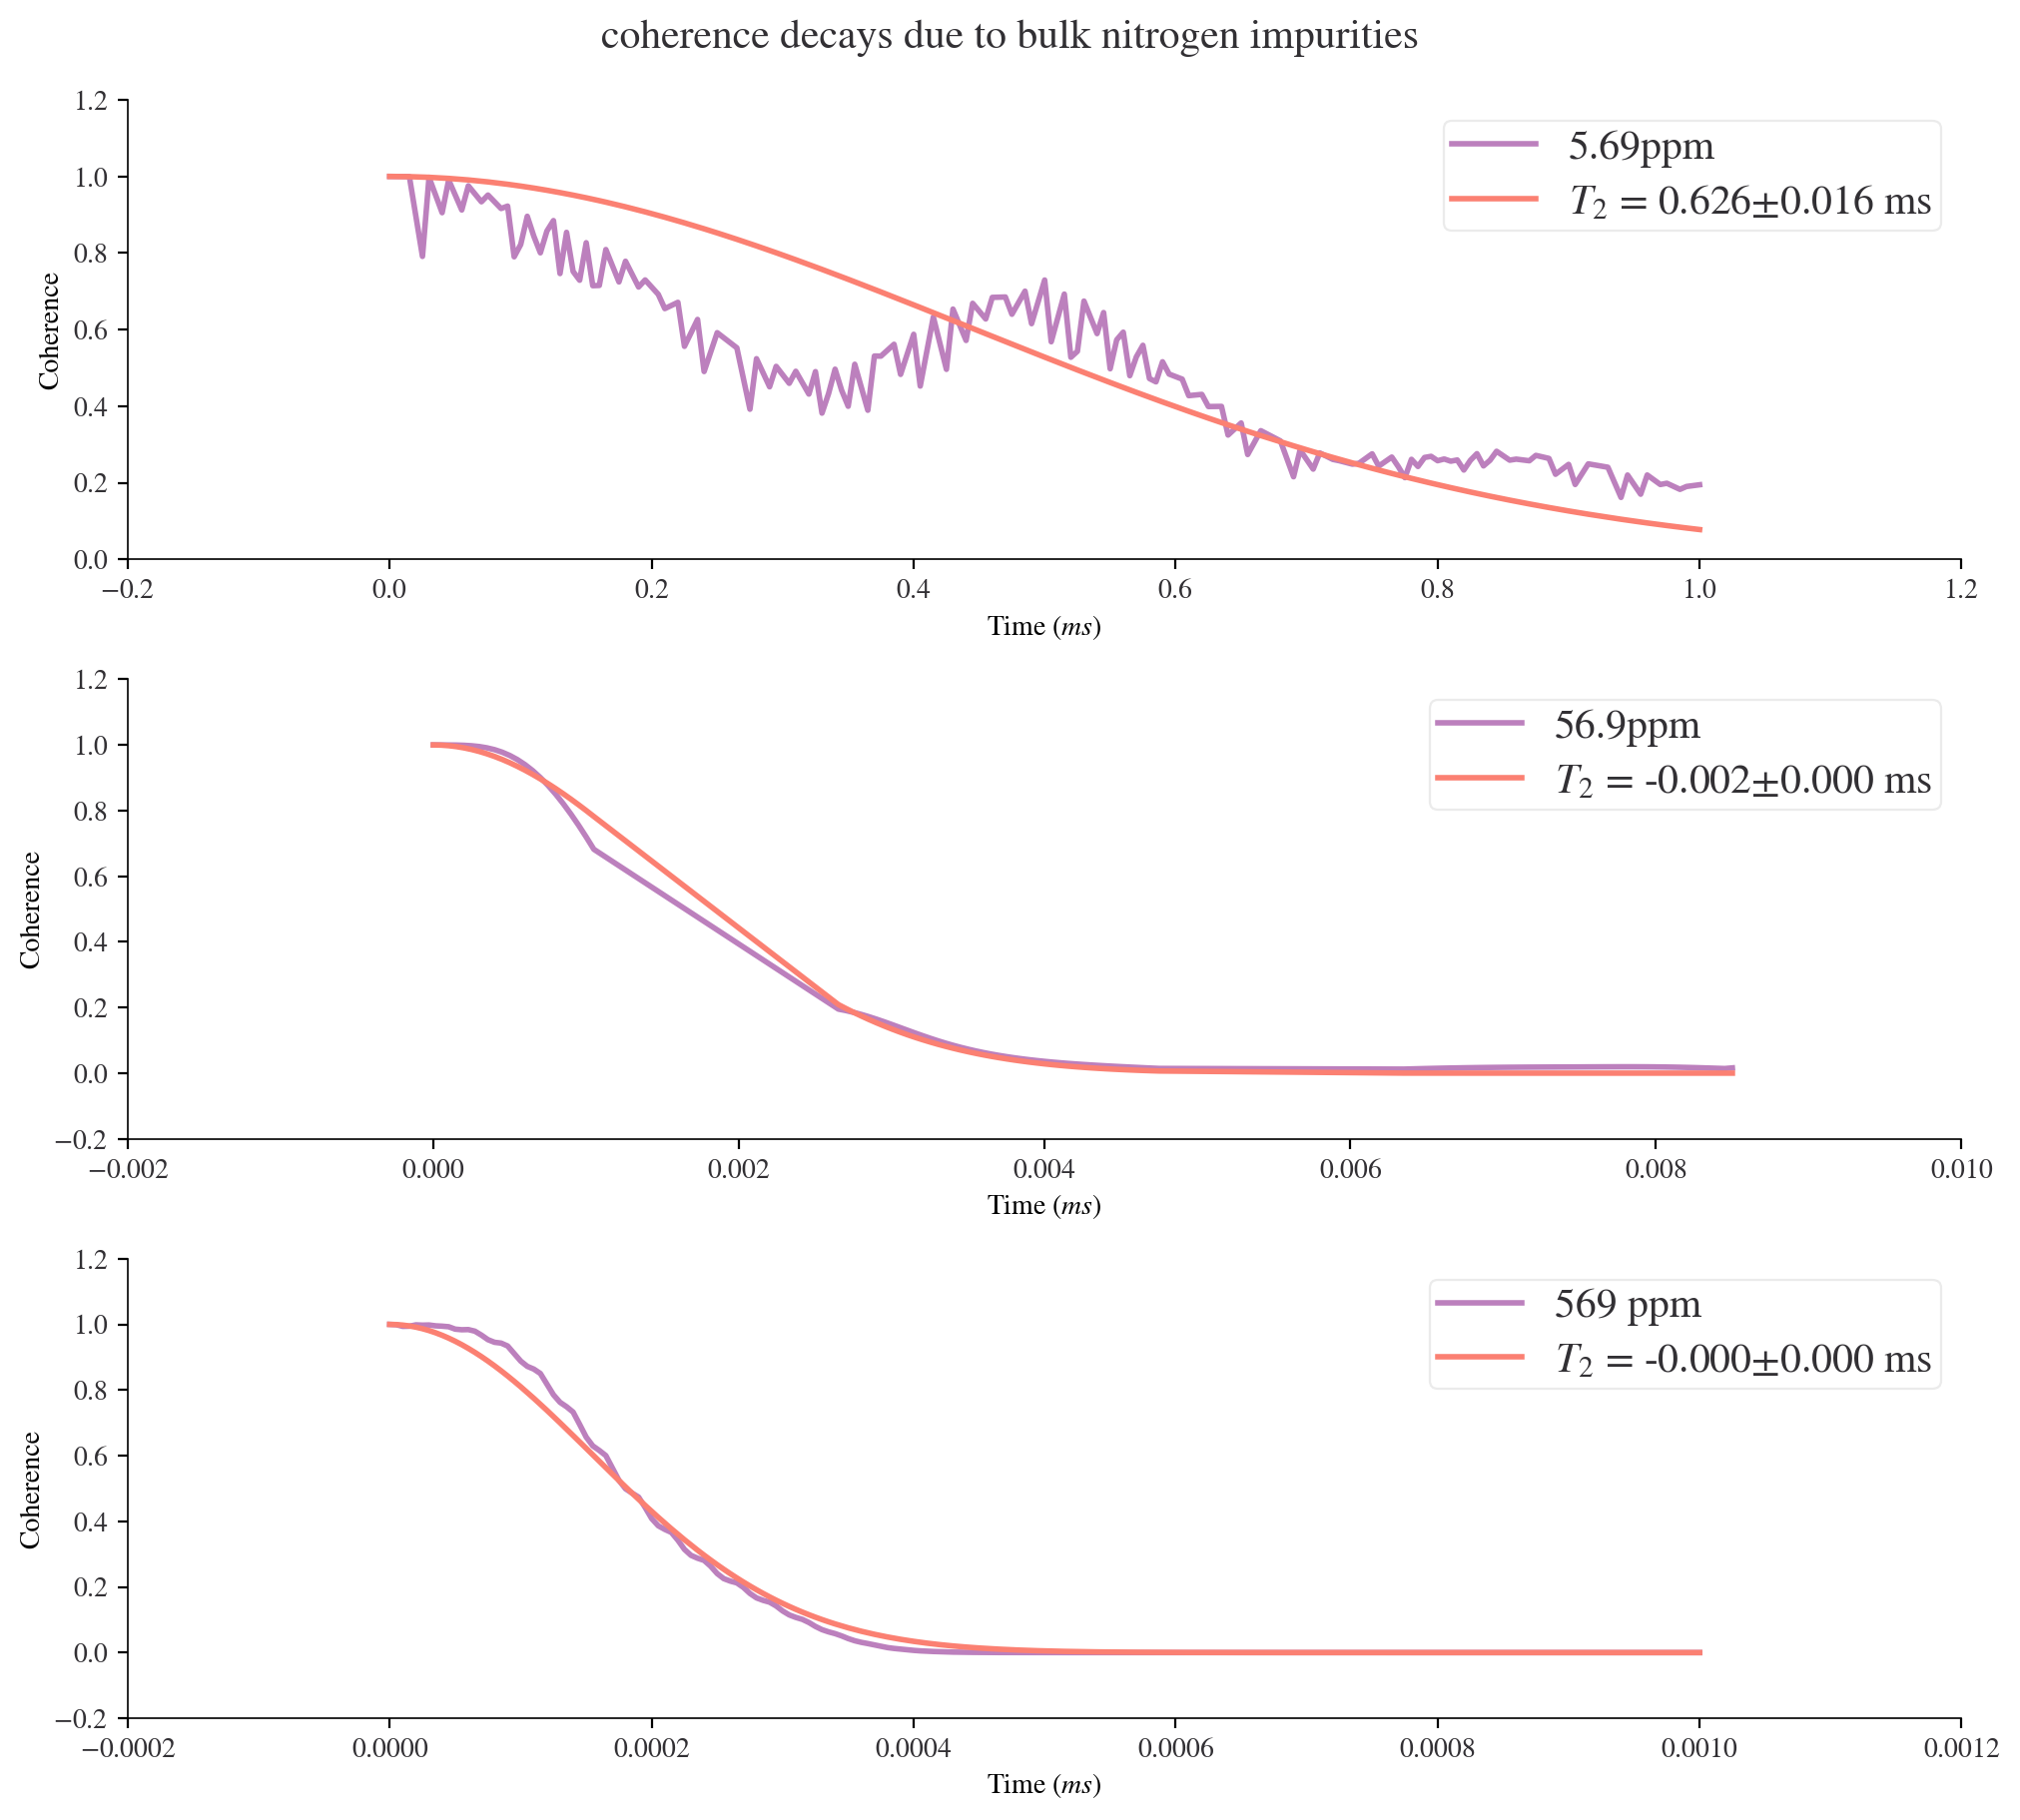

In [131]:
''' import libraries '''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import ase
import warnings
from mpl_toolkits import mplot3d
from ase.build import bulk
import pycce.filter
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib as mpl
import time

"""set up seed for bath generations"""
seed = 8805
np.random.seed(seed)
seedN = 7000
np.random.seed(seedN)
np.set_printoptions(suppress=True, precision=10)

plt.style.use('plot_style.txt')
# plt.style.use('plot_style.txt')
mpl.rcParams['figure.figsize'] = [10.0, 9.0]
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['axes.labelsize'] = 10.0


#######################################################################################################################
########## conc = 5.69 ppm ##########
#######################################################################################################################

starttime = time.perf_counter()

''' generate 1 nitrogen within a 10x10x10 nm^3 cube '''
nitrogen = pc.random_bath('14N', [100, 100, 100], density=1e18,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
nitrogen.zdir = [1,1,1]

''' generate 1 electron within a 10x10x10 nm^3 cube '''
electron = pc.random_bath('e', [100, 100, 100], density=1e18,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
electron.zdir = [1,1,1]

''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 180  # in A
# Cluster cutoff radius
r_dipole = 100  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [0,0,0]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,nitrogen,electron]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 1, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_far = []
l_generatilze_fixed_far = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
        l_generatilze_fixed_far.append(l_generatilze_test[i])
        time_space_generatilze_fixed_far.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_far,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_far, l_generatilze_fixed_far)
T2_var_far = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_far = coherence_fit(time_space_generatilze_fixed_far, T2_gen_far)

endtime = time.perf_counter()
print(starttime-endtime,"seconds taken for calc 1")

#######################################################################################################################
########## conc = 56.9 ppm ##########
#######################################################################################################################

starttime = time.perf_counter()

''' generate 10 nitrogen within a 10x10x10 nm^3 cube '''
nitrogen = pc.random_bath('14N', [100, 100, 100], density=1e19,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
nitrogen.zdir = [1,1,1]

''' generate 10 electron within a 10x10x10 nm^3 cube '''
electron = pc.random_bath('e', [100, 100, 100], density=1e19,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
electron.zdir = [1,1,1]

''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 180  # in A
# Cluster cutoff radius
r_dipole = 100  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [0,0,0]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,nitrogen,electron]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 0.01, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_mid = []
l_generatilze_fixed_mid = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
        l_generatilze_fixed_mid.append(l_generatilze_test[i])
        time_space_generatilze_fixed_mid.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_mid,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_mid, l_generatilze_fixed_mid)
T2_var_mid = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_mid = coherence_fit(time_space_generatilze_fixed_mid, T2_gen_mid)

endtime = time.perf_counter()
print(starttime-endtime,"seconds for calc 2")

#######################################################################################################################
########## conc = 569 ppm ##########
#######################################################################################################################

starttime = time.perf_counter()

''' generate 100 nitrogen within a 10x10x10 nm^3 cube '''
nitrogen = pc.random_bath('14N', [100, 100, 100], density=1e20,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
nitrogen.zdir = [1,1,1]

''' generate 100 electron within a 10x10x10 nm^3 cube '''
electron = pc.random_bath('e', [100, 100, 100], density=1e20,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
electron.zdir = [1,1,1]

''' generate spin bath of 13C in a 10x10x10 nm^3 diamond lattice '''
# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(100, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]), seed=seed)


"""setup for coherence calculation"""

# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 180  # in A
# Cluster cutoff radius
r_dipole = 100  # in A

# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# position of central spin
position = [0,0,0]

# generate central spin
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,nitrogen,electron]),
                    r_bath=r_bath, r_dipole=r_dipole, order=order)



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

"coherence calculation"


"general"
# Time points
time_space = np.linspace(0, 0.001, 201)  # in ms

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function with general method
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')


''' filter faulty points '''
l_generatilze_test = l_generatilze.real

time_space_generatilze_fixed_near = []
l_generatilze_fixed_near = []
for i in np.arange(0,201):
    if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
        l_generatilze_fixed_near.append(l_generatilze_test[i])
        time_space_generatilze_fixed_near.append(time_space[i])


''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

#popt: Optimized parameters
#pcov: matrix of covariance.
T2_gen_near,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed_near, l_generatilze_fixed_near)
T2_var_near = np.sqrt(np.abs(T2_var))

# calculates the y value using the Gaussian function
y_gen_near = coherence_fit(time_space_generatilze_fixed_near, T2_gen_near)

endtime = time.perf_counter()
print(starttime-endtime,"seconds for calc 3")

################################################################################

plt.figure()
fig, axes = plt.subplots(3,1, constrained_layout = True)
fig.suptitle('coherence decays due to bulk nitrogen impurities', size=15)

axes[0].plot(time_space_generatilze_fixed_far, l_generatilze_fixed_far, label='5.69ppm', ls='-')
axes[0].plot(time_space_generatilze_fixed_far, y_gen_far, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_far[0],T2_var_far[0][0]))
axes[0].set_xlabel('Time ($ms$)')
axes[0].set_ylabel('Coherence')
axes[0].legend()

axes[1].plot(time_space_generatilze_fixed_mid, l_generatilze_fixed_mid, label='56.9ppm', ls='-')
axes[1].plot(time_space_generatilze_fixed_mid, y_gen_mid, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_mid[0],T2_var_mid[0][0]))
axes[1].set_xlabel('Time ($ms$)')
axes[1].set_ylabel('Coherence')
axes[1].legend()

axes[2].plot(time_space_generatilze_fixed_near, l_generatilze_fixed_near, label='569 ppm', ls='-')
axes[2].plot(time_space_generatilze_fixed_near, y_gen_near, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_near[0],T2_var_near[0][0]))
axes[2].set_xlabel('Time ($ms$)')
axes[2].set_ylabel('Coherence')
axes[2].legend()


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<Figure size 2000x1800 with 0 Axes>

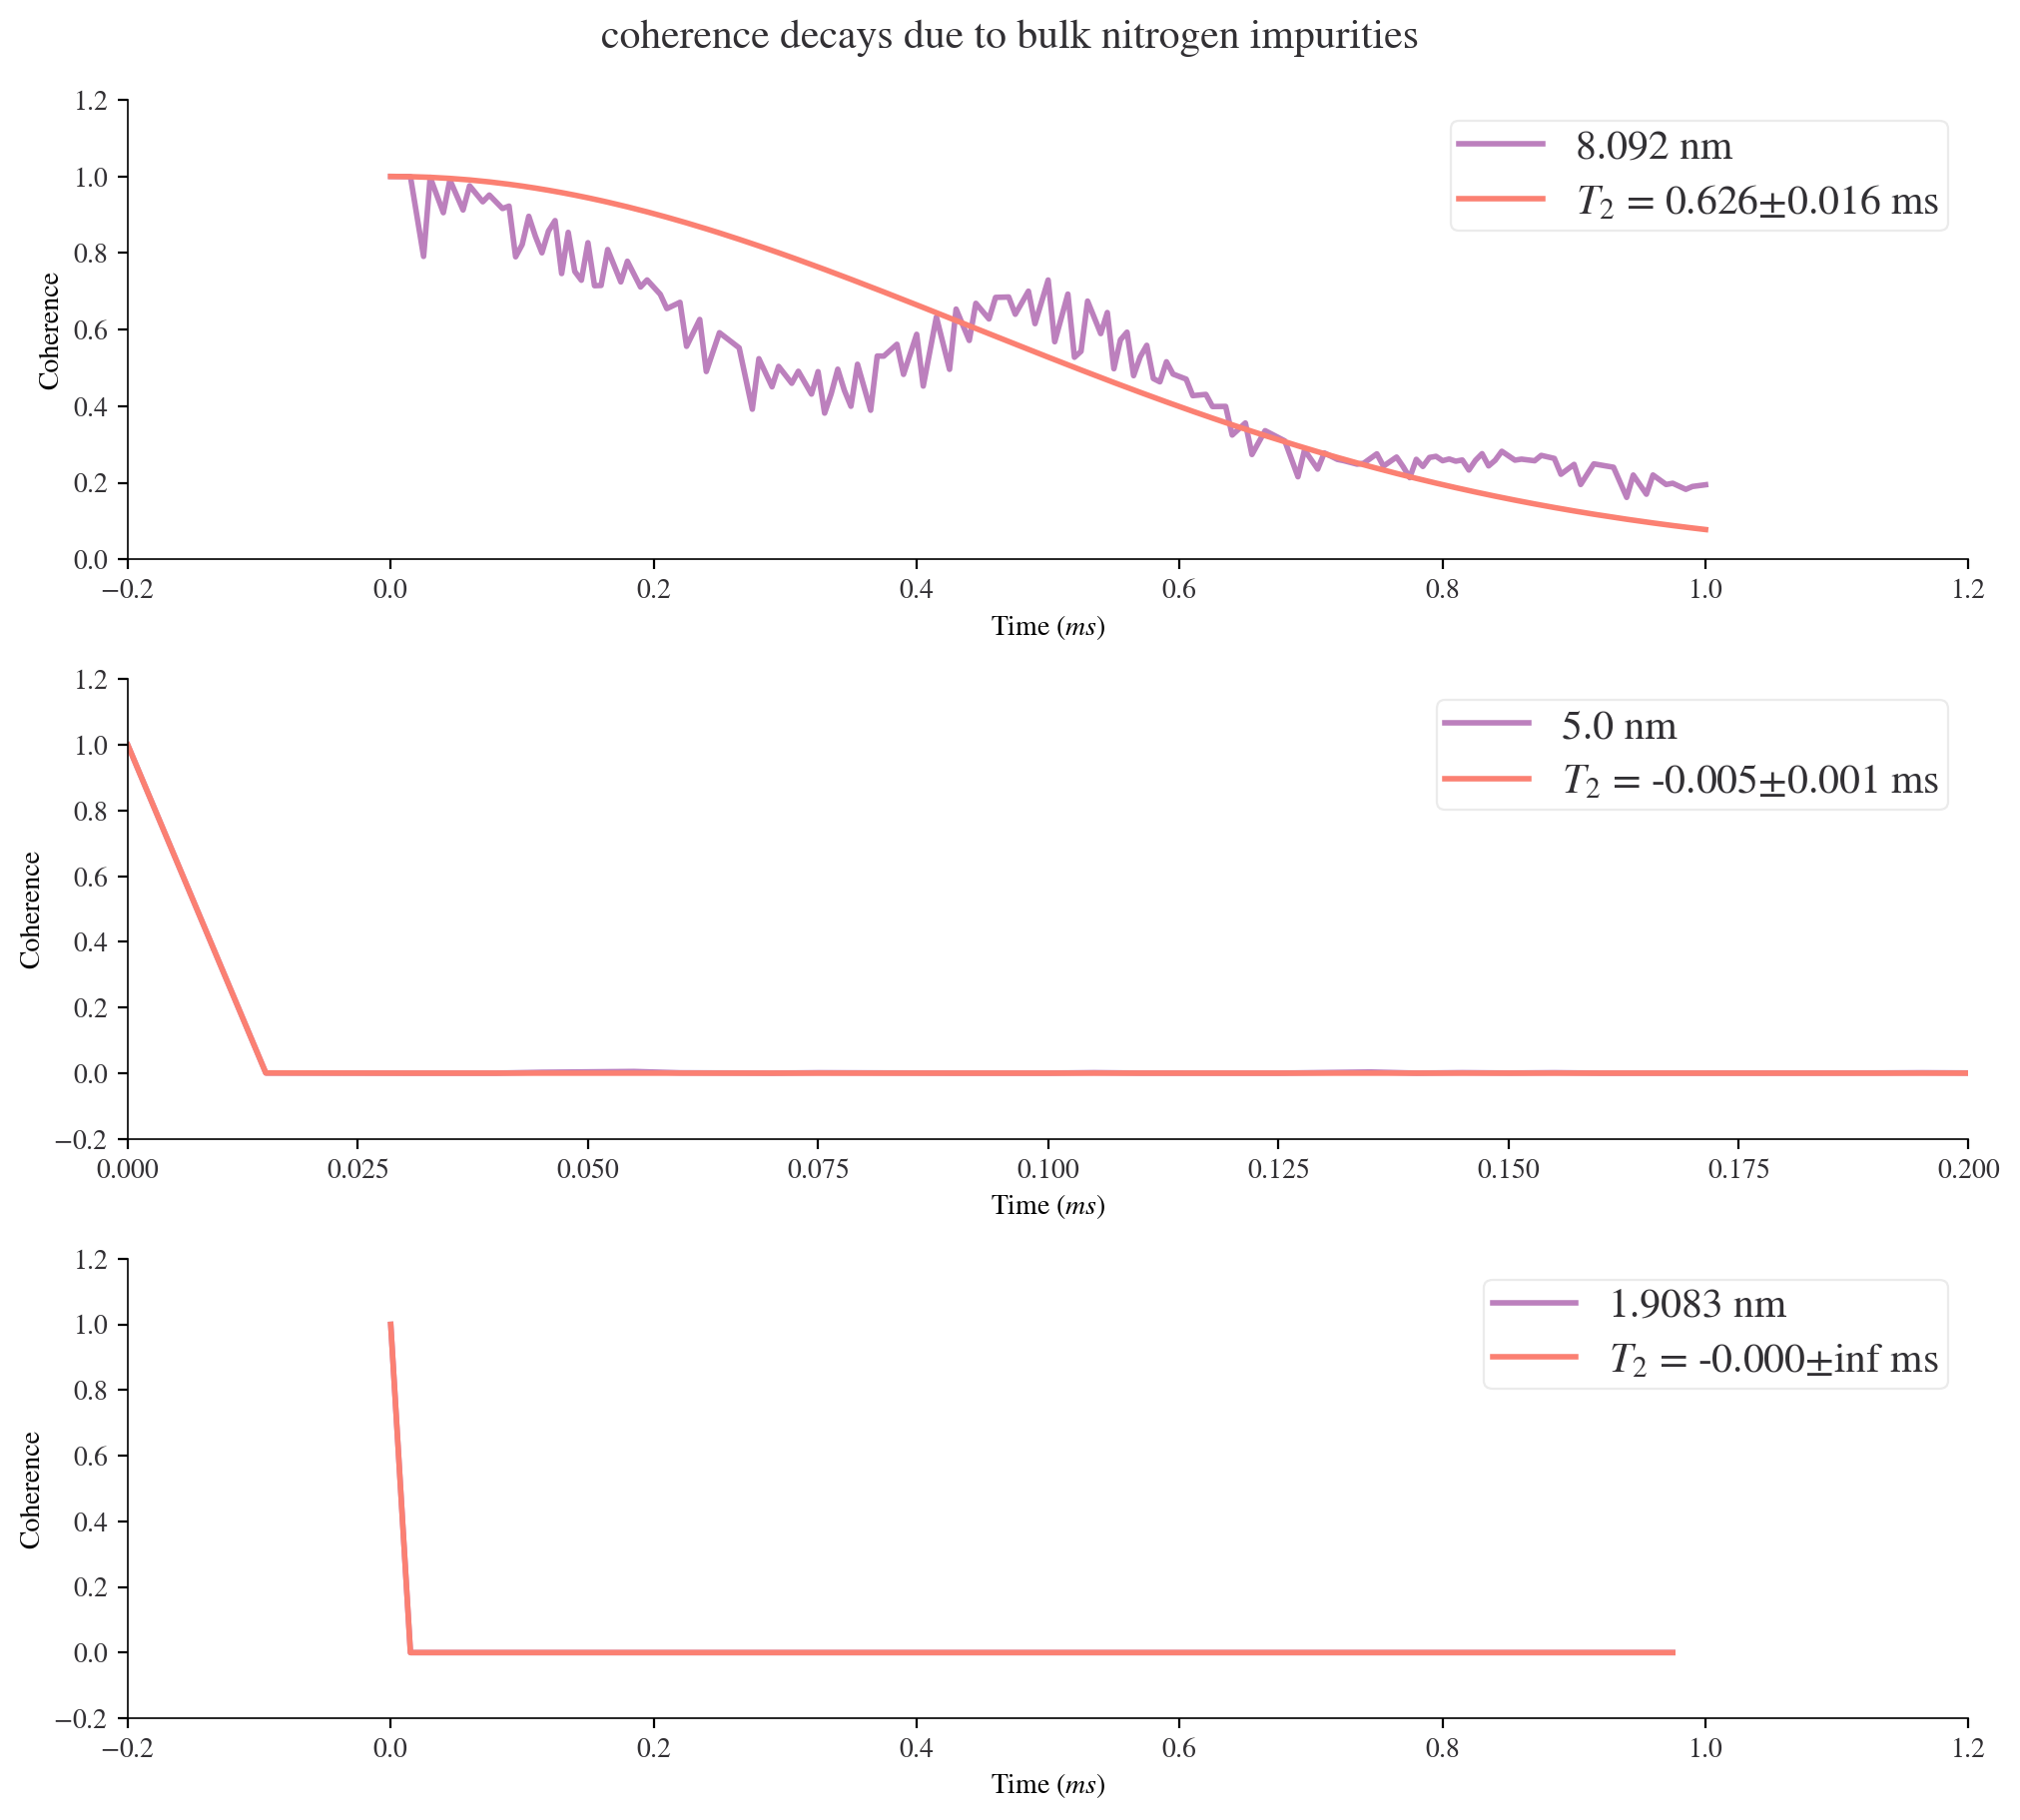

In [130]:
plt.style.use('plot_style.txt')
# plt.style.use('plot_style.txt')
mpl.rcParams['figure.figsize'] = [10.0, 9.0]
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['axes.labelsize'] = 10.0

plt.figure()
fig, axes = plt.subplots(3,1, constrained_layout = True)
fig.suptitle('coherence decays due to bulk nitrogen impurities', size=15)

axes[0].plot(time_space_generatilze_fixed_far, l_generatilze_fixed_far, label='5.69 ppm', ls='-')
axes[0].plot(time_space_generatilze_fixed_far, y_gen_far, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_far[0],T2_var_far[0][0]))
axes[0].set_xlabel('Time ($ms$)')
axes[0].set_ylabel('Coherence')
axes[0].legend()

axes[1].plot(time_space_generatilze_fixed_mid, l_generatilze_fixed_mid, label='56.9 ppm', ls='-')
axes[1].plot(time_space_generatilze_fixed_mid, y_gen_mid, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_mid[0],T2_var_mid[0][0]))
axes[1].set_xlabel('Time ($ms$)')
axes[1].set_ylabel('Coherence')
axes[1].set_xlim(0,0.2)
axes[1].legend()

axes[2].plot(time_space_generatilze_fixed_near, l_generatilze_fixed_near, label='569 ppm', ls='-')
axes[2].plot(time_space_generatilze_fixed_near, y_gen_near, '-', label='$T_2$ = {0:0.3f}$\pm${1:0.3f} ms'.format(T2_gen_near[0],T2_var_near[0][0]))
axes[2].set_xlabel('Time ($ms$)')
axes[2].set_ylabel('Coherence')
axes[2].legend()



Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<Figure size 2000x1800 with 0 Axes>

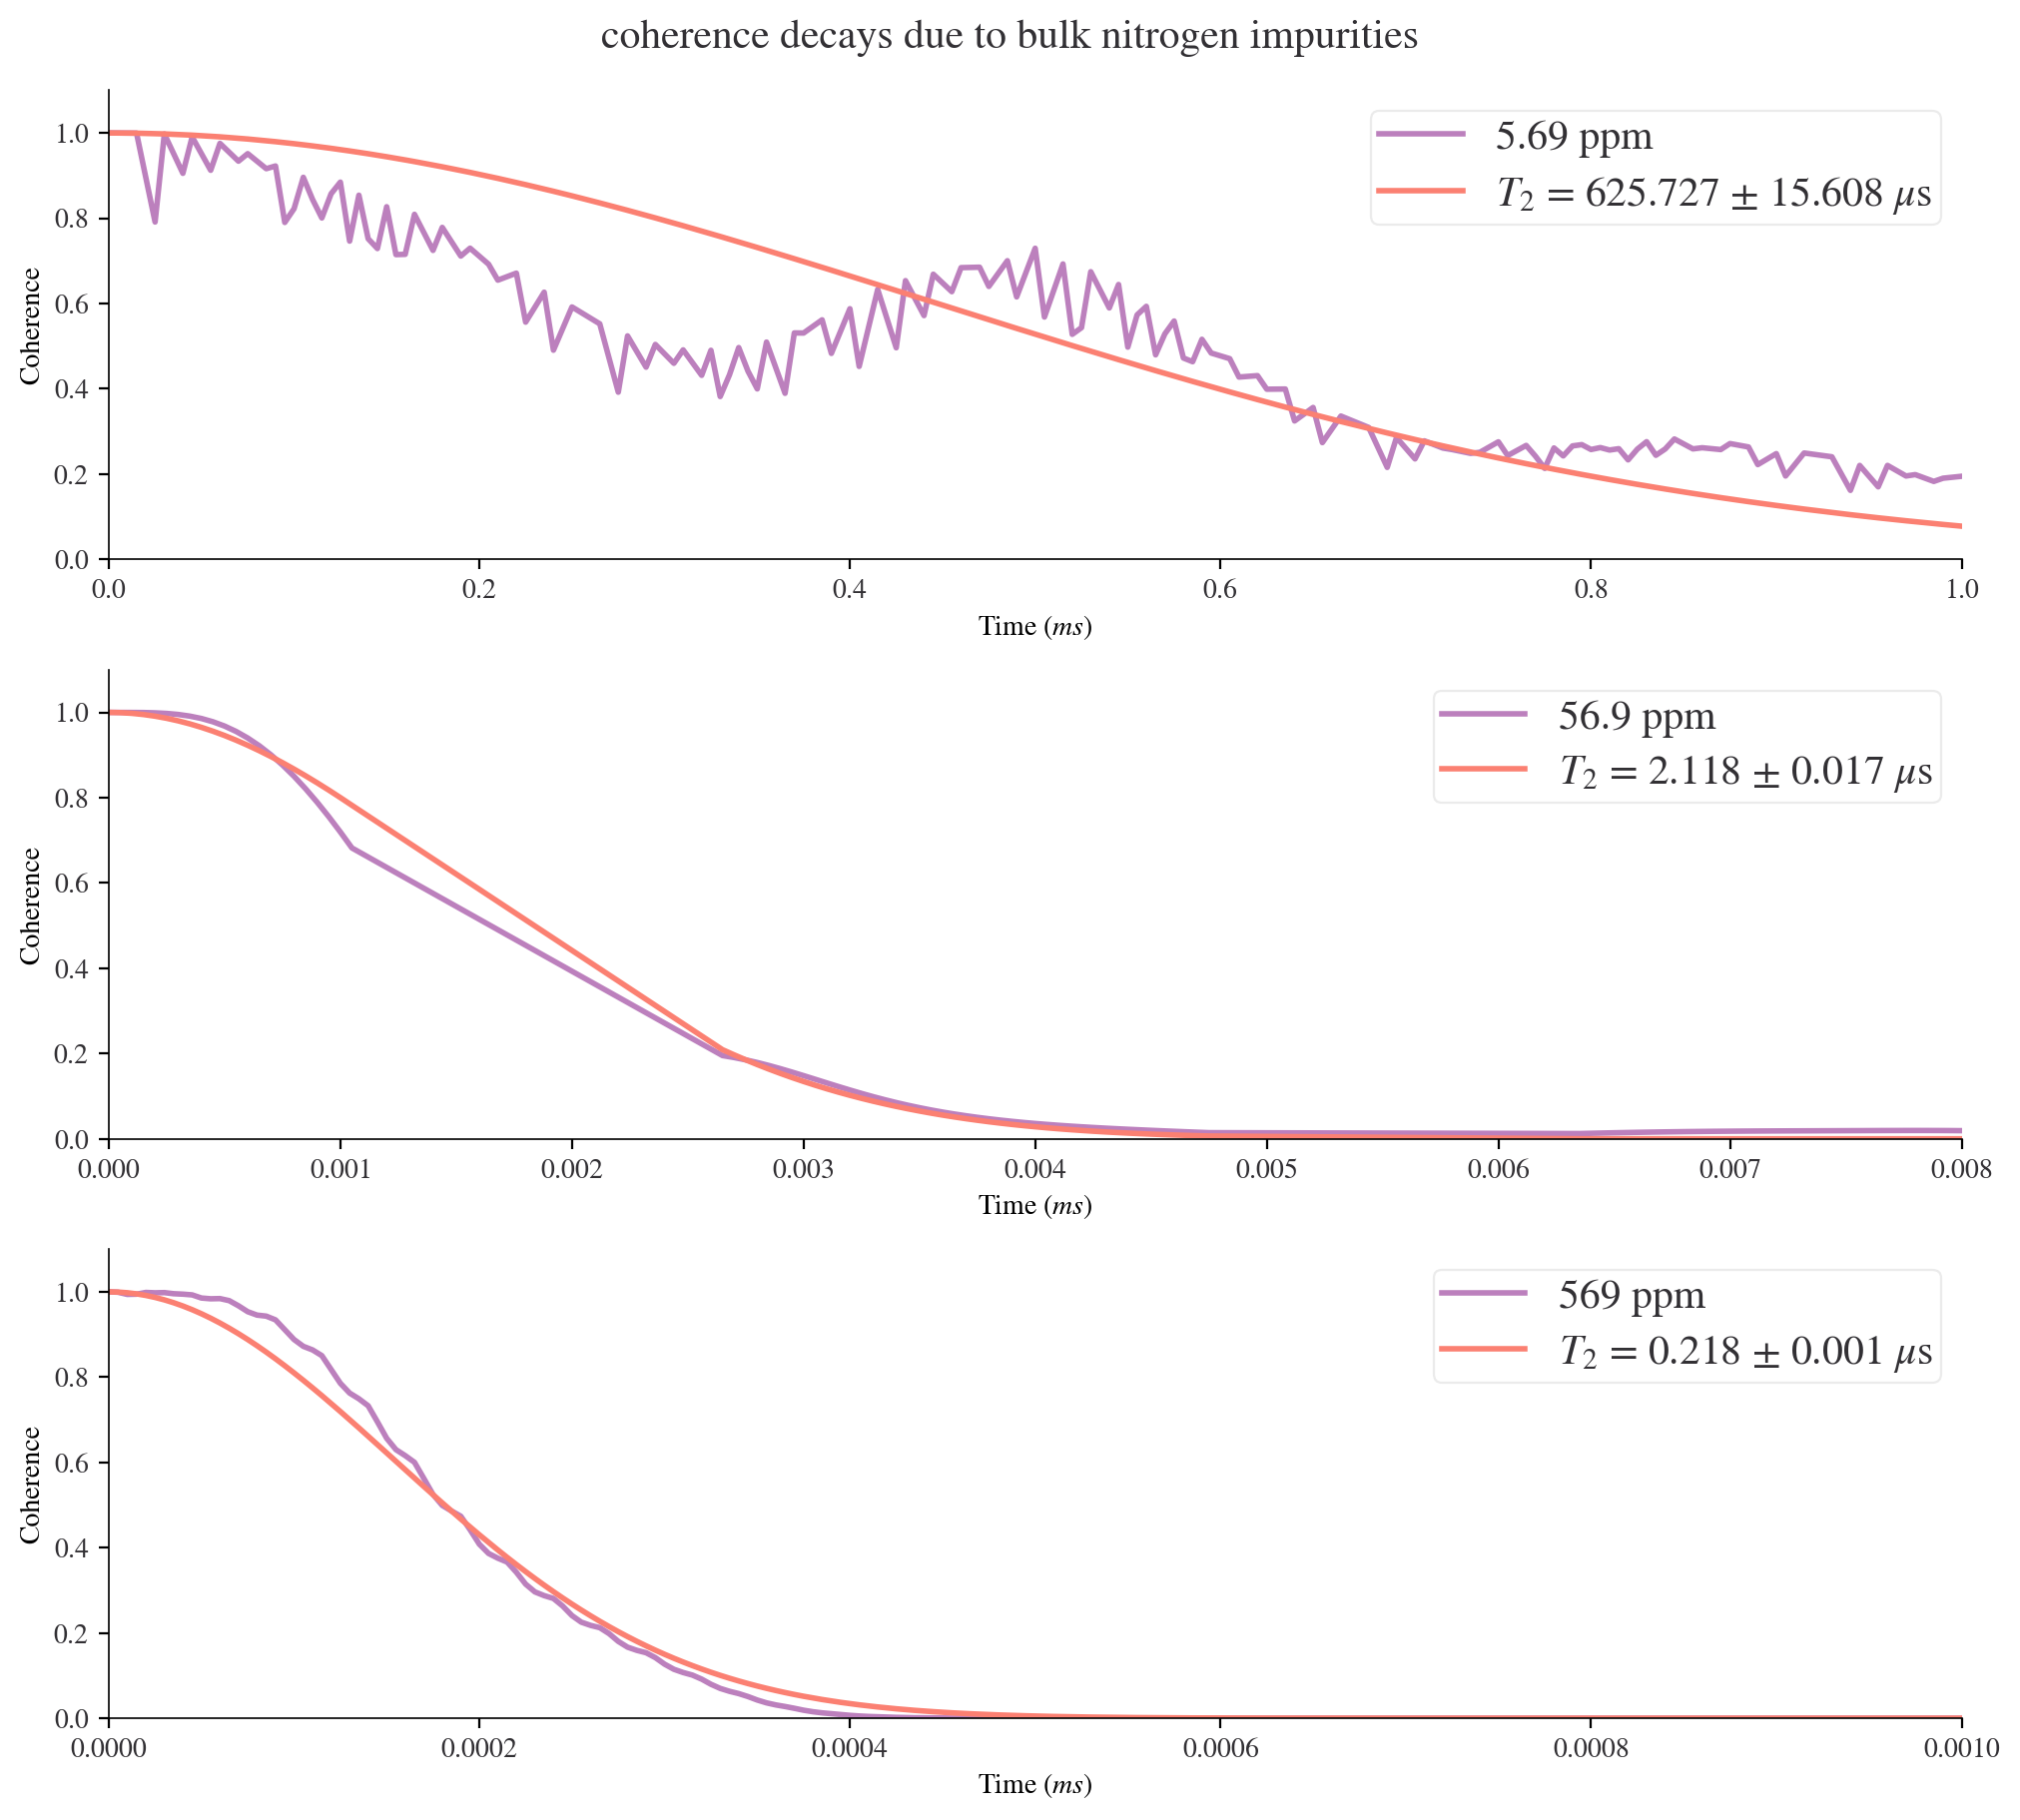

In [164]:
plt.style.use('plot_style.txt')
# plt.style.use('plot_style.txt')
mpl.rcParams['figure.figsize'] = [10.0, 9.0]
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['axes.labelsize'] = 10.0

plt.figure()
fig, axes = plt.subplots(3,1, constrained_layout = True)
fig.suptitle('coherence decays due to bulk nitrogen impurities', size=15)

axes[0].plot(time_space_generatilze_fixed_far, l_generatilze_fixed_far, label='5.69 ppm', ls='-')
axes[0].plot(time_space_generatilze_fixed_far, y_gen_far, '-', label='$T_2$ = {0:0.3f} $\pm$ {1:0.3f} $\mu$s'.format(T2_gen_far[0]*1000,T2_var_far[0][0]*1000))
axes[0].set_xlabel('Time ($ms$)')
axes[0].set_ylabel('Coherence')
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1.1)
axes[0].legend()

axes[1].plot(time_space_generatilze_fixed_mid, l_generatilze_fixed_mid, label='56.9 ppm', ls='-')
axes[1].plot(time_space_generatilze_fixed_mid, y_gen_mid, '-', label='$T_2$ = {0:0.3f} $\pm$ {1:0.3f} $\mu$s'.format(np.abs(T2_gen_mid[0]*1000),T2_var_mid[0][0]*1000))
axes[1].set_xlabel('Time ($ms$)')
axes[1].set_ylabel('Coherence')
axes[1].set_xlim(0,0.008)
axes[1].set_ylim(0,1.1)
axes[1].legend()

axes[2].plot(time_space_generatilze_fixed_near, l_generatilze_fixed_near, label='569 ppm', ls='-')
axes[2].plot(time_space_generatilze_fixed_near, y_gen_near, '-', label='$T_2$ = {0:0.3f} $\pm$ {1:0.3f} $\mu$s'.format(np.abs(T2_gen_near[0]*1000),T2_var_near[0][0]*1000))
axes[2].set_xlabel('Time ($ms$)')
axes[2].set_ylabel('Coherence')
axes[2].set_xlim(0,0.001)
axes[2].set_ylim(0,1.1)
axes[2].legend()

datasavefile = 'self_datapoints_T2_mix_5.69ppm_rand.csv'
data_mix_T2_conc = {'time_space_generatilze_fixed_far':time_space_generatilze_fixed_far, 'l_generatilze_fixed_far':l_generatilze_fixed_far}
df = pd.DataFrame(data = data_mix_T2_conc)
df.to_csv(datasavefile)

datasavefile = 'self_datapoints_T2_mix_56.9ppm_rand.csv'
data_mix_T2_conc = {'time_space_generatilze_fixed_mid':time_space_generatilze_fixed_mid, 'l_generatilze_fixed_mid':l_generatilze_fixed_mid}
df = pd.DataFrame(data = data_mix_T2_conc)
df.to_csv(datasavefile)

datasavefile = 'self_datapoints_T2_mix_569ppm_rand.csv'
data_mix_T2_conc = {'time_space_generatilze_fixed_near':time_space_generatilze_fixed_near, 'l_generatilze_fixed_near':l_generatilze_fixed_near}
df = pd.DataFrame(data = data_mix_T2_conc)
df.to_csv(datasavefile)

outpath = 'self_atomnumb_T2_mix_3conc_rand.png'
plt.savefig(outpath)


Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


-5166.223109 secs for calc 1
-4865.2833502 secs for calc 2
-1824.7607131000004 secs for calc 3


C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:172: RuntimeWarning: overflow encountered in power
  vcalc = contribution_operator(vcalc, current_power[index])
C:\Users\Daniel Low\Anaconda3\lib\site-packages\pycce\run\clusters.py:174: RuntimeWarning: invalid value encountered in multiply
  result = result_operator(result, vcalc)


-1649.1185846000008 secs for calc 4
-1669.4085039000001 secs for calc 5
-1547.9986453000001 secs for calc 6
-1540.5800610000006 secs for calc 7
-1602.3940339999972 secs for calc 8
-1484.9514920999973 secs for calc 9
-1526.5798952000005 secs for calc 10
-1605.2568857000006 secs for calc 11
-2178.0235732 secs for calc 12
-1601.239428500001 secs for calc 13
-1699.9408989999974 secs for calc 14
-1880.801870999996 secs for calc 15
-1889.6406712000025 secs for calc 16
-1877.880133999999 secs for calc 17
-1988.8519594000027 secs for calc 18
-2009.6636543000059 secs for calc 19
-2049.6531830999957 secs for calc 20


C:\Users\Daniel Low\Anaconda3\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


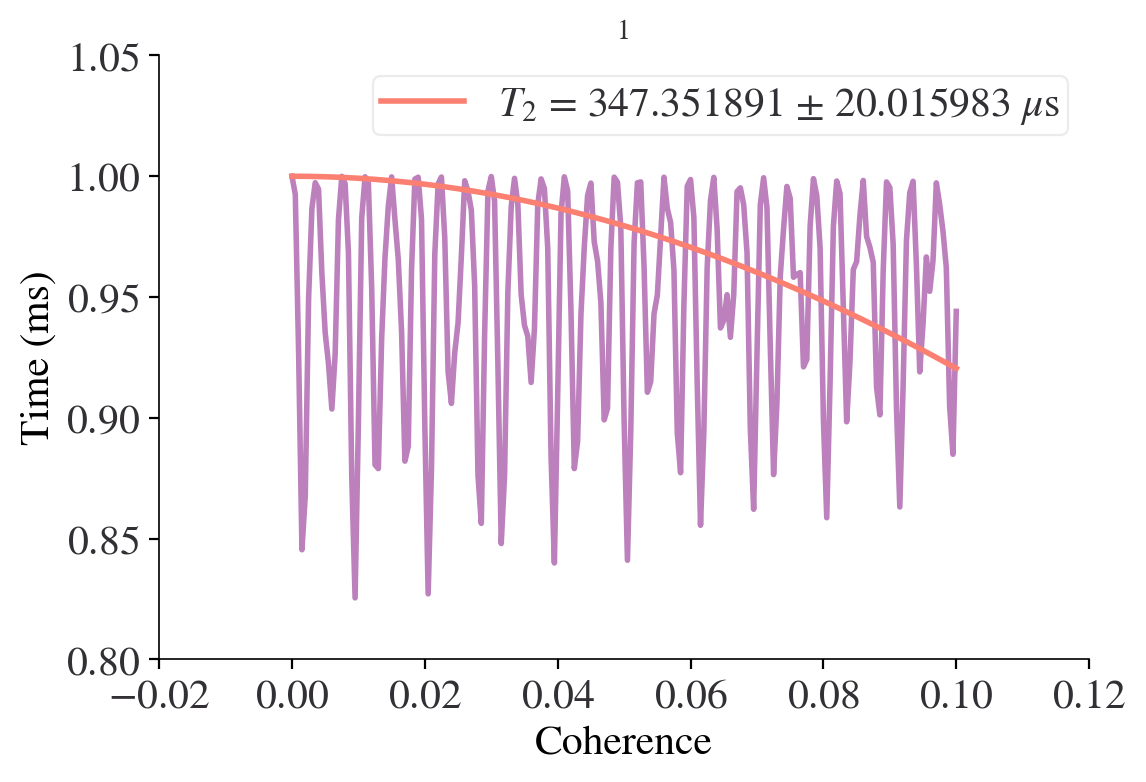

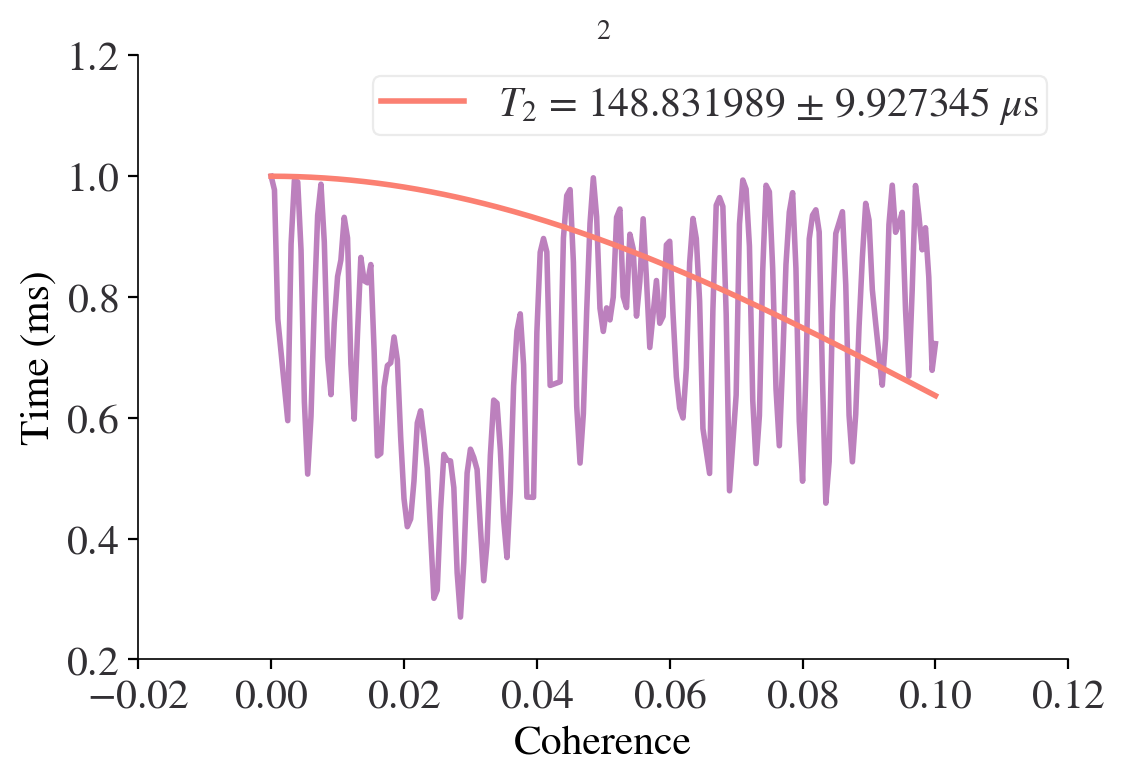

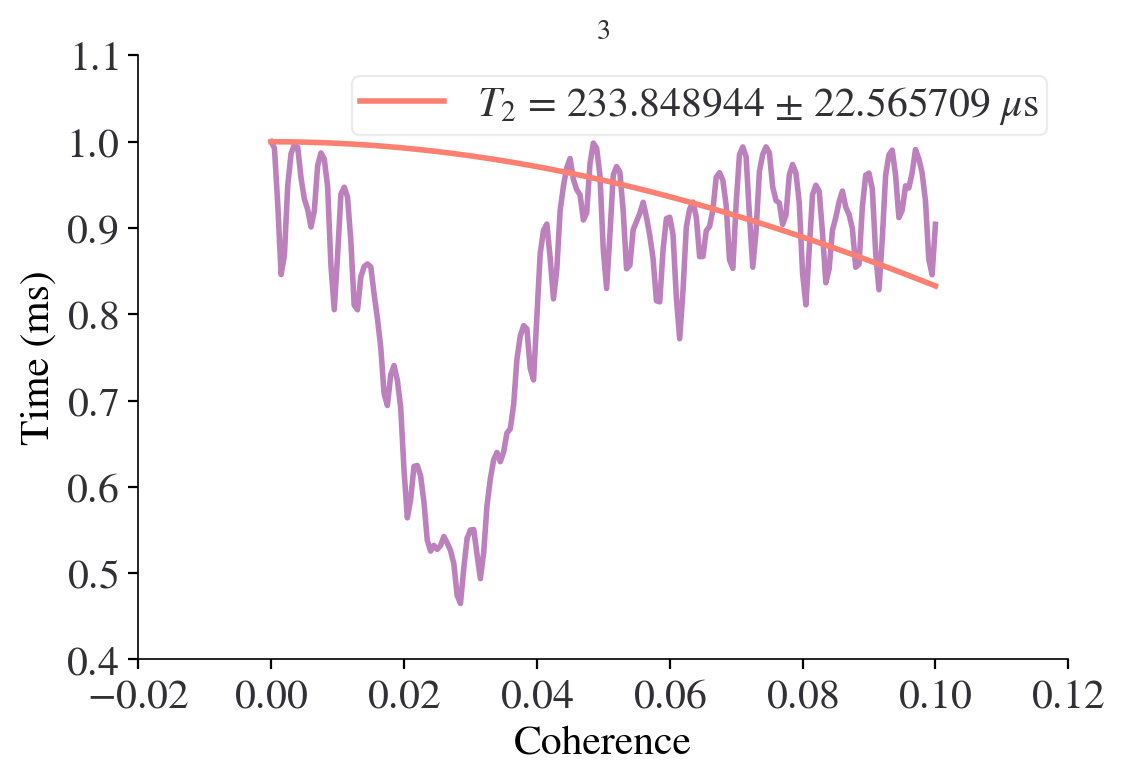

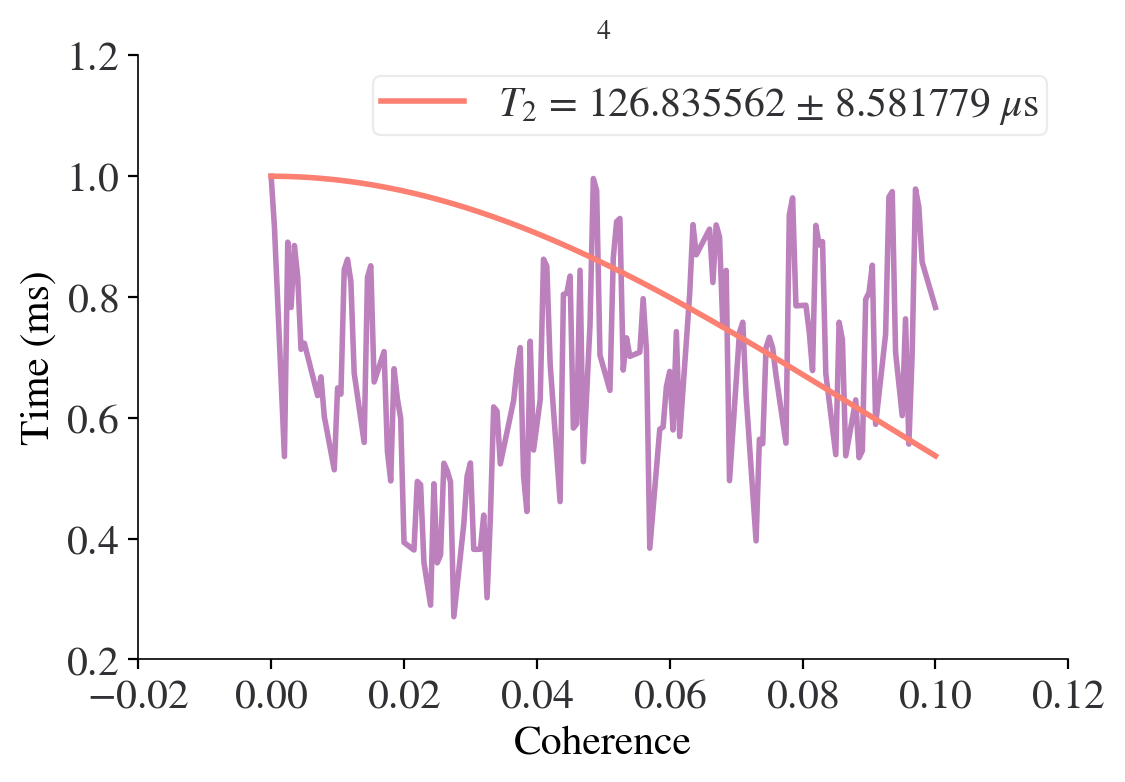

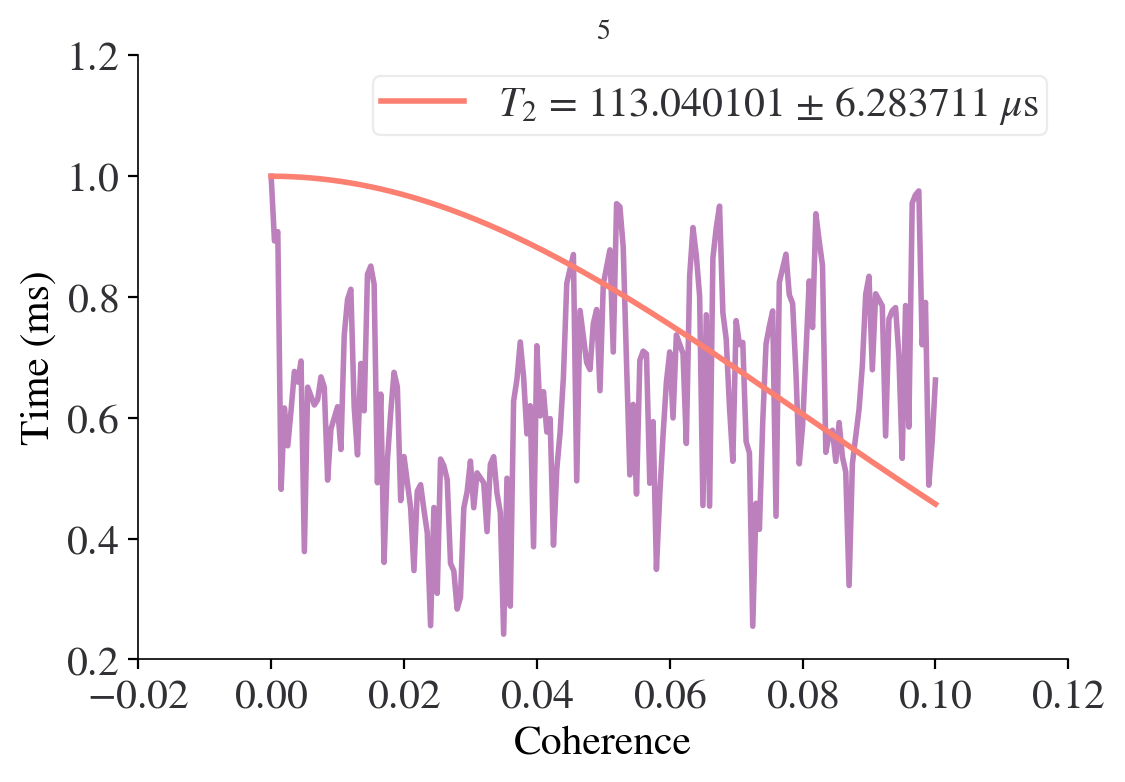

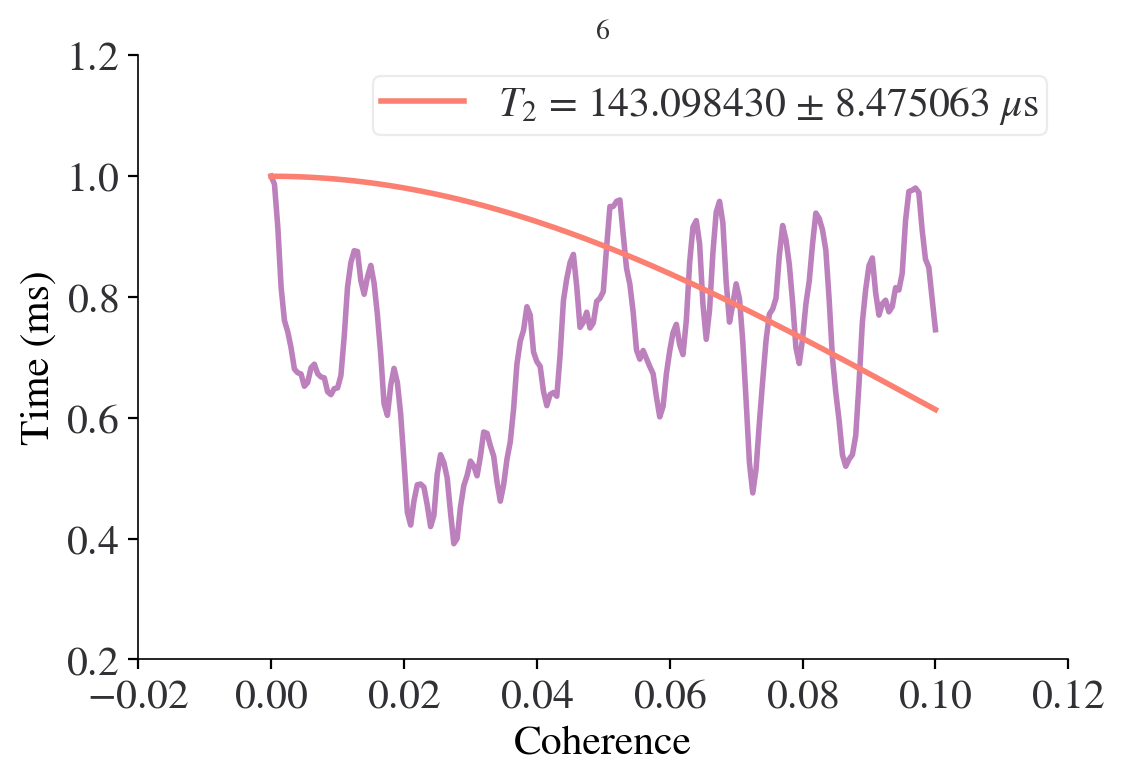

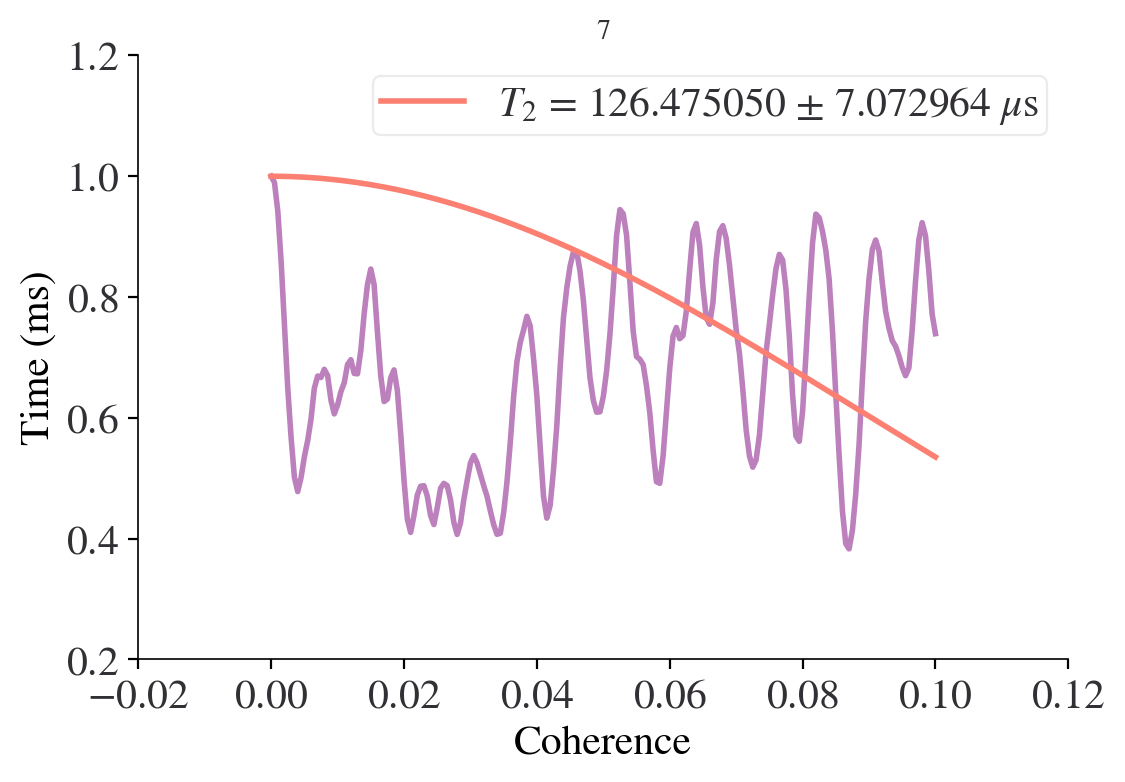

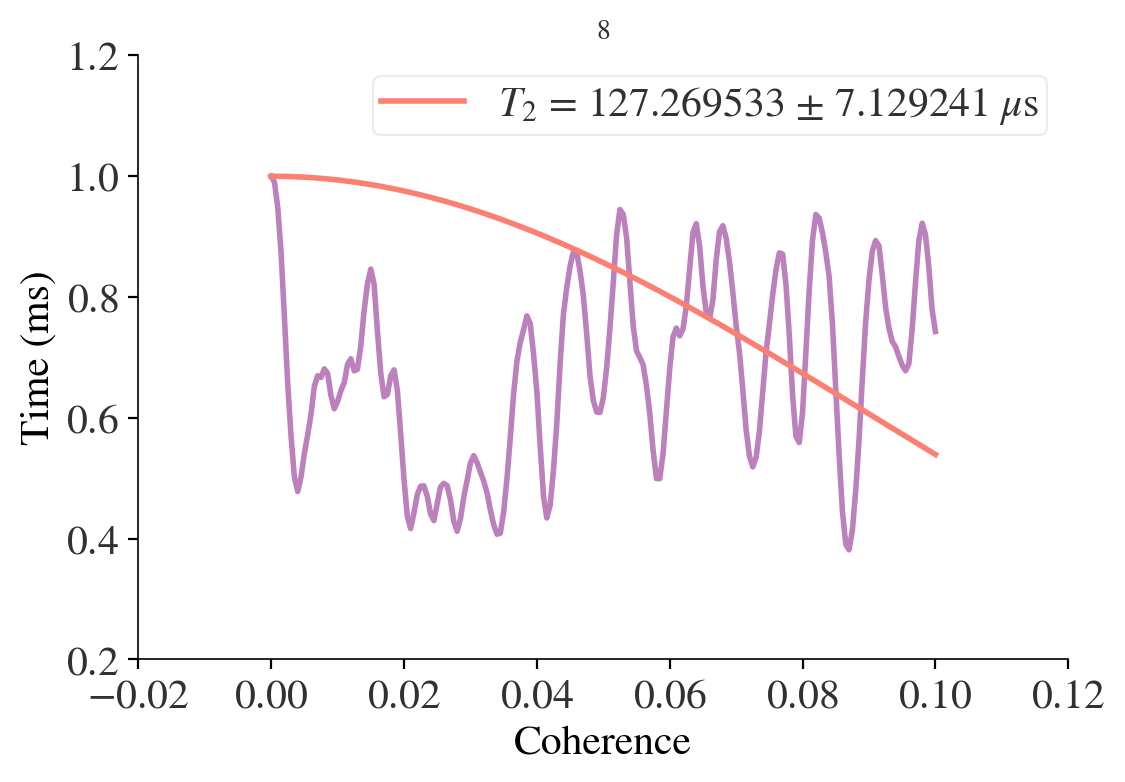

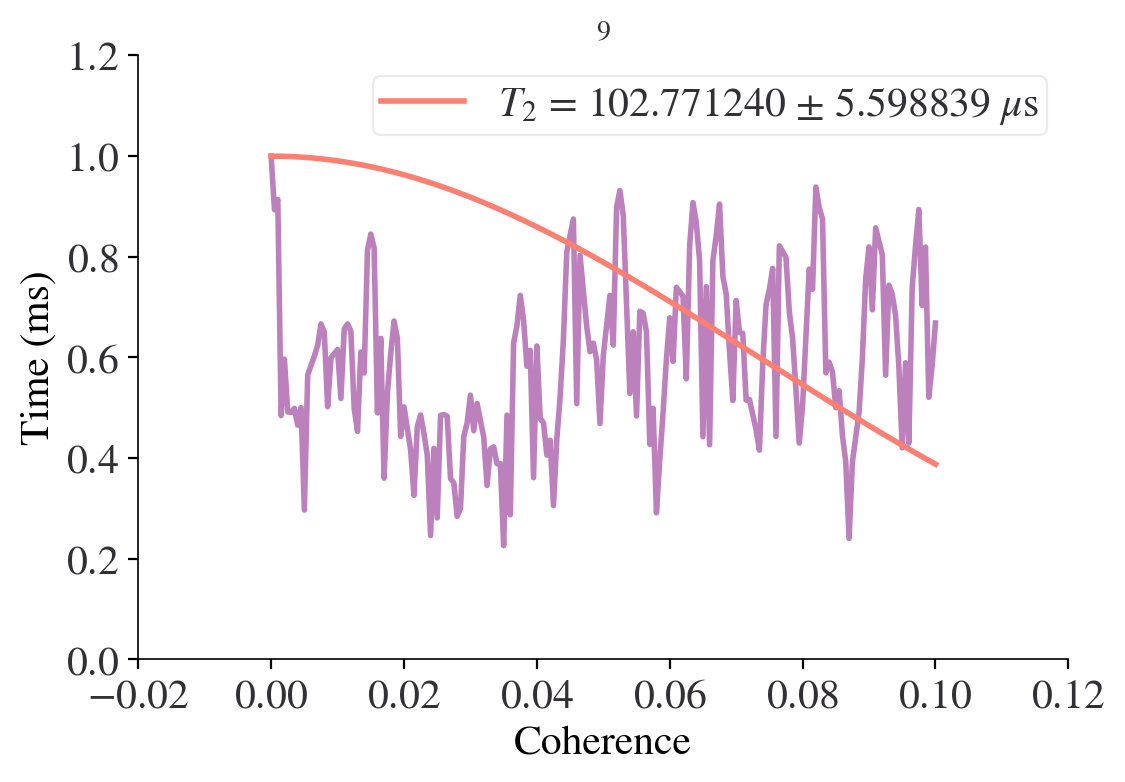

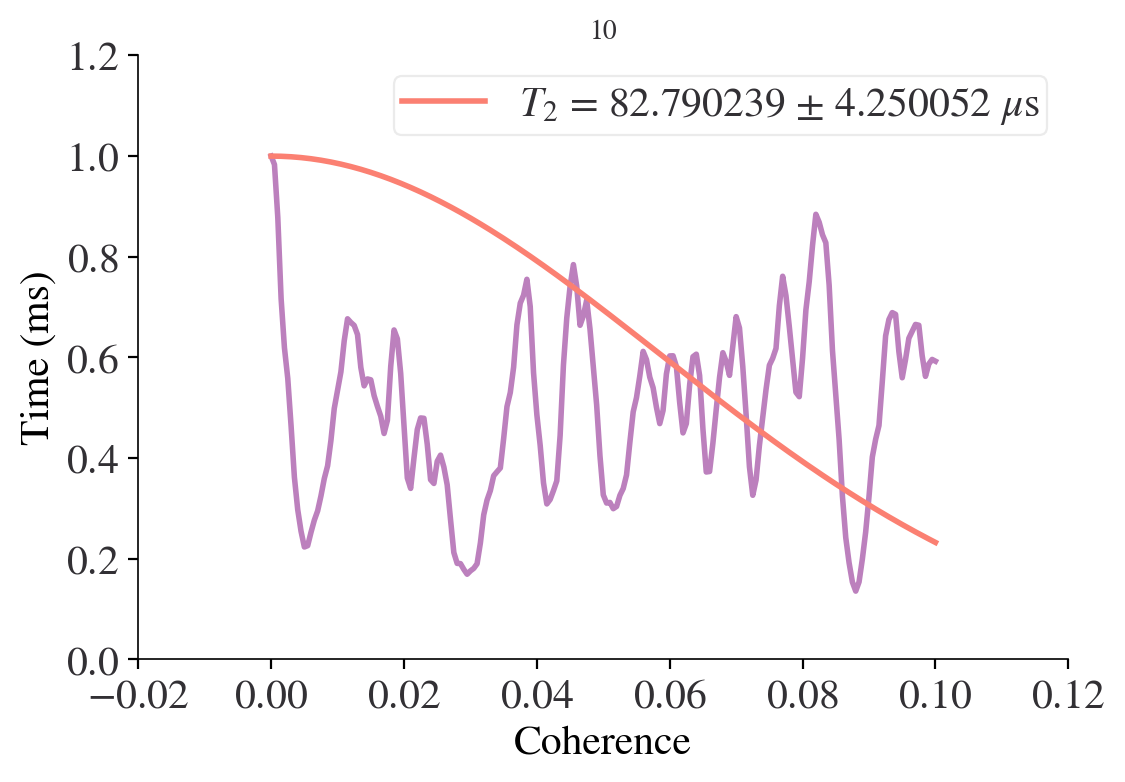

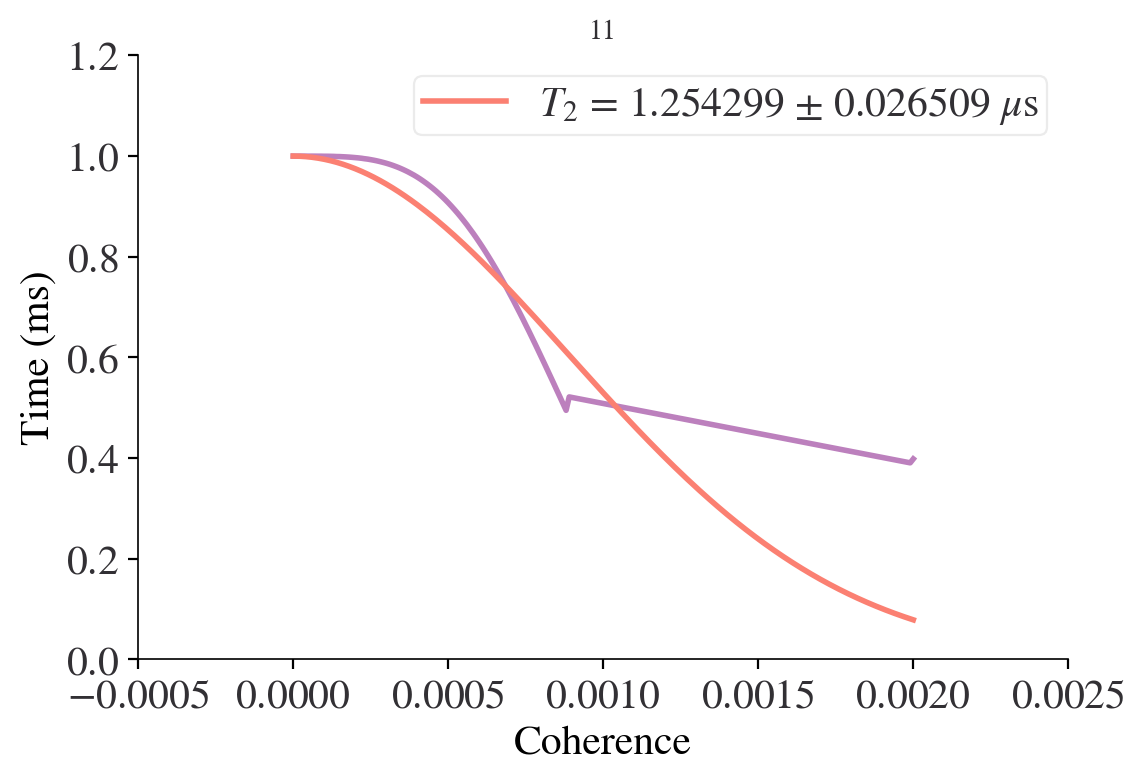

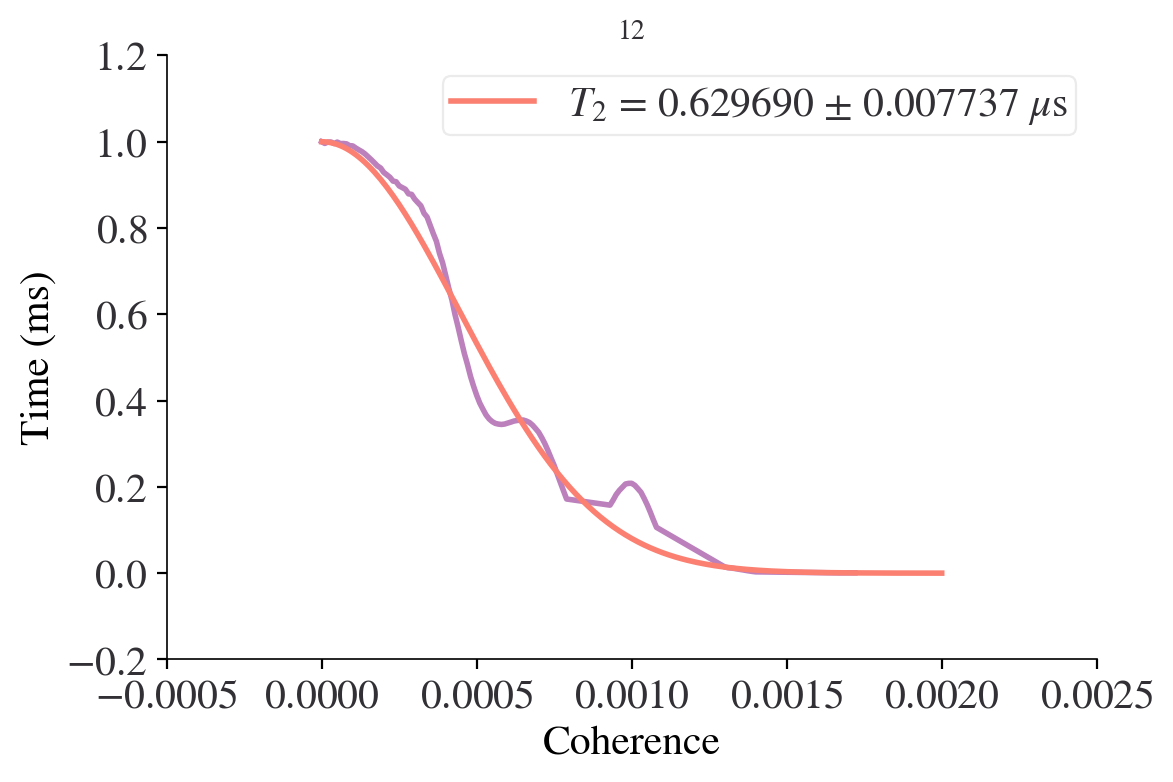

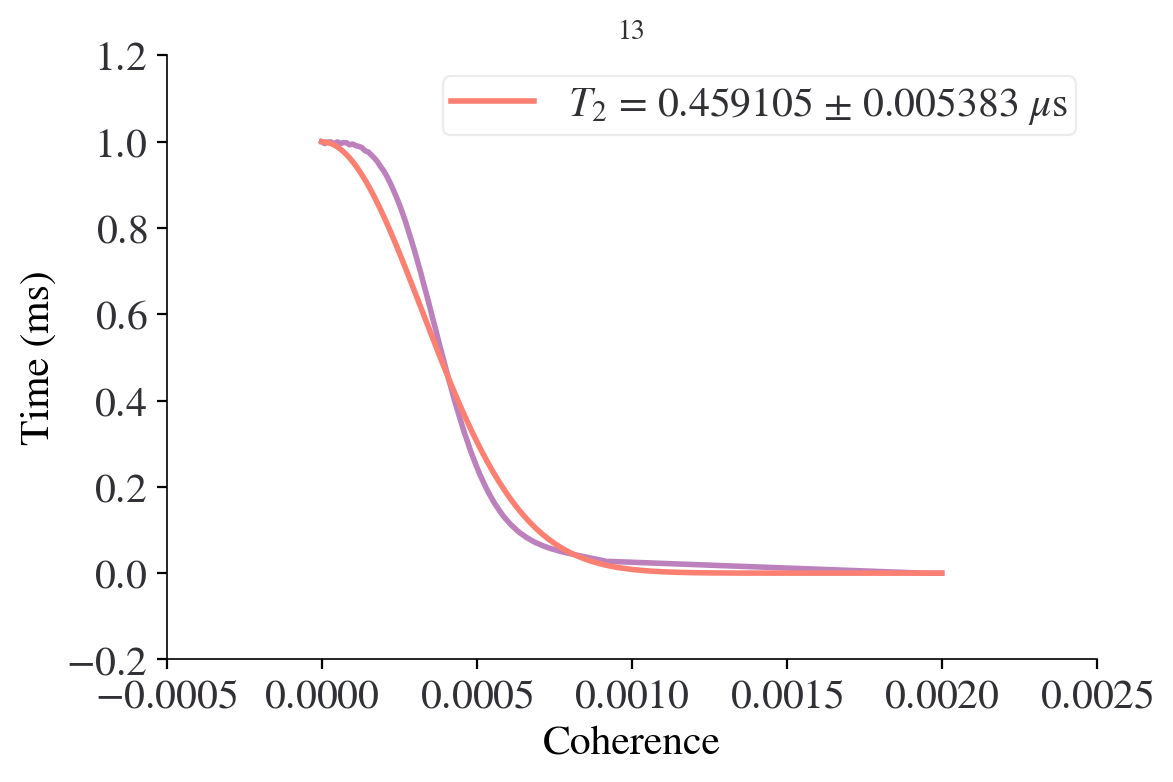

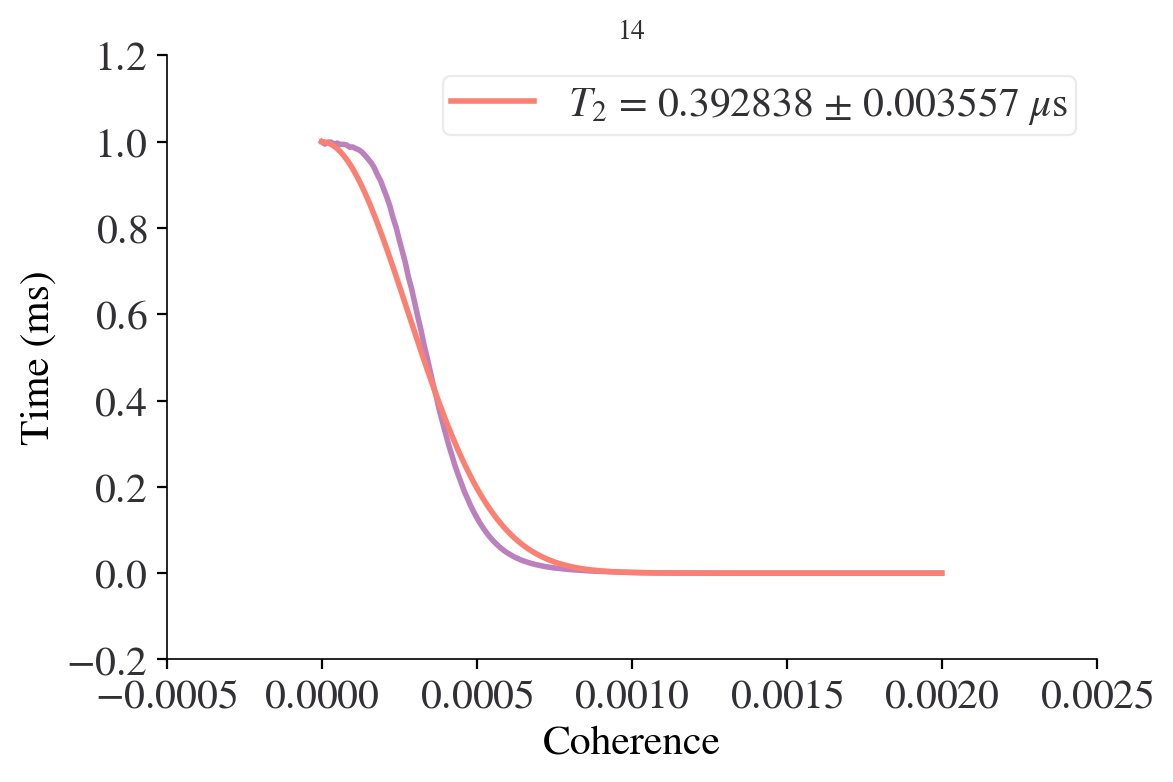

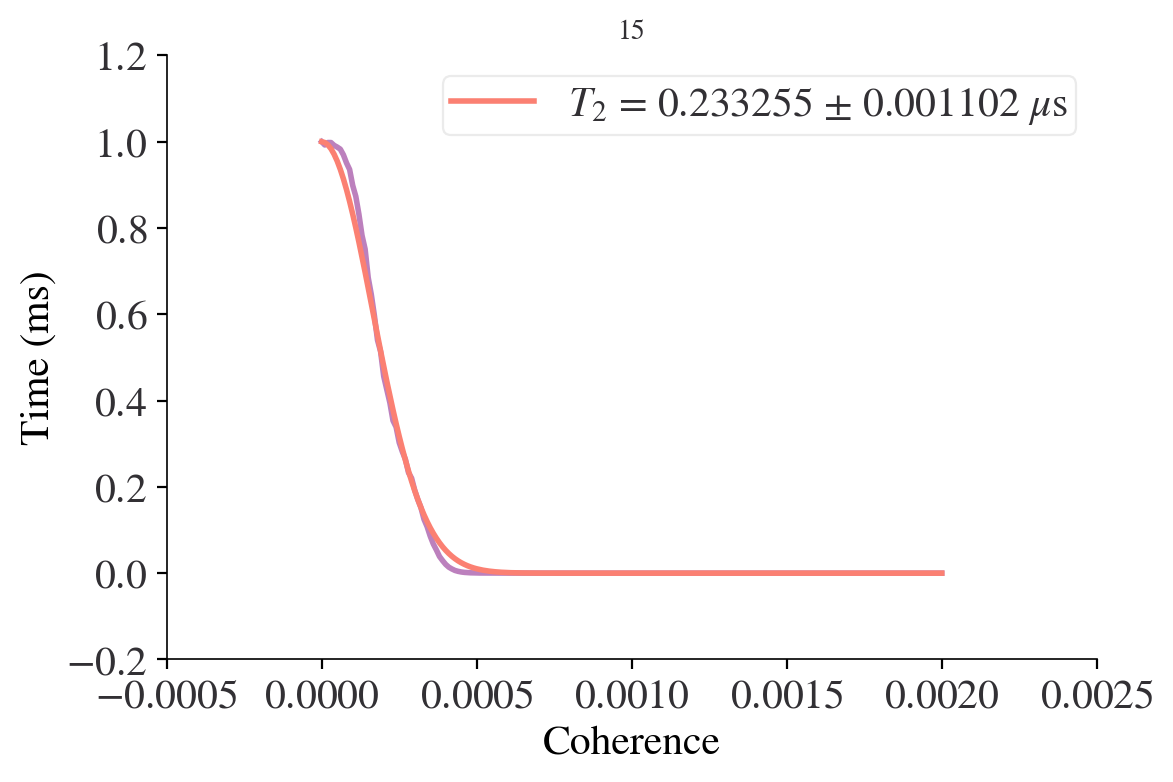

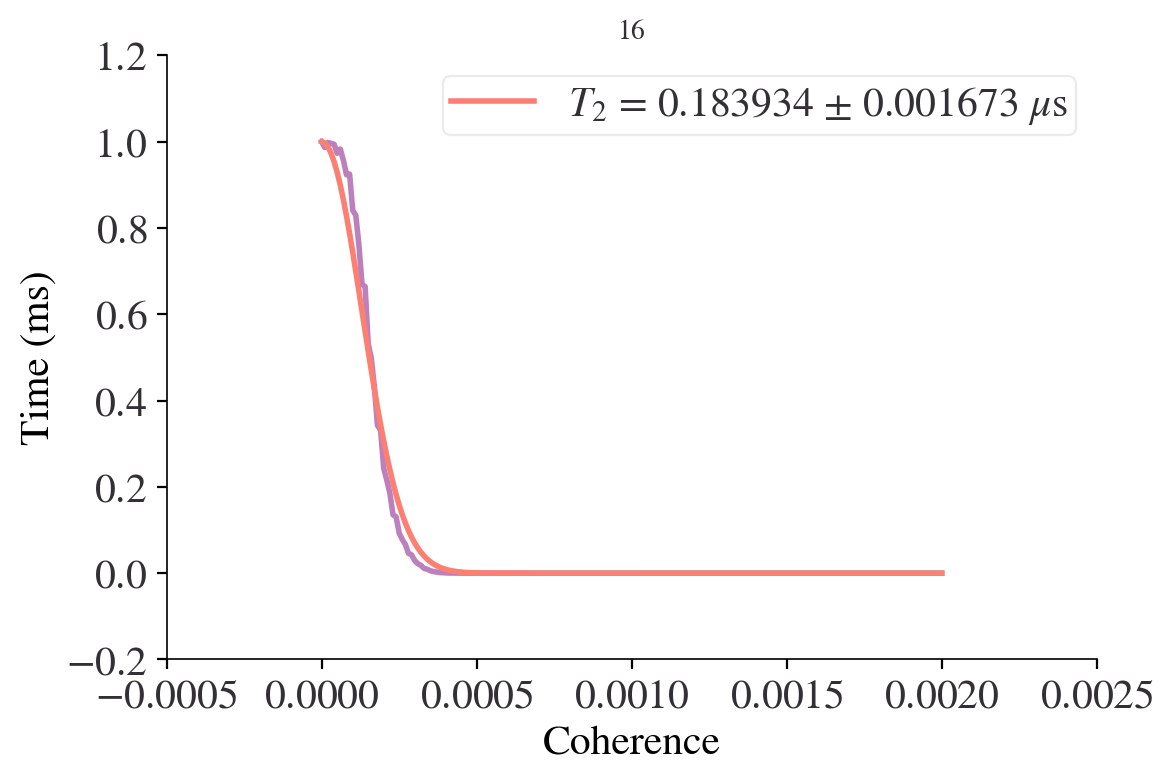

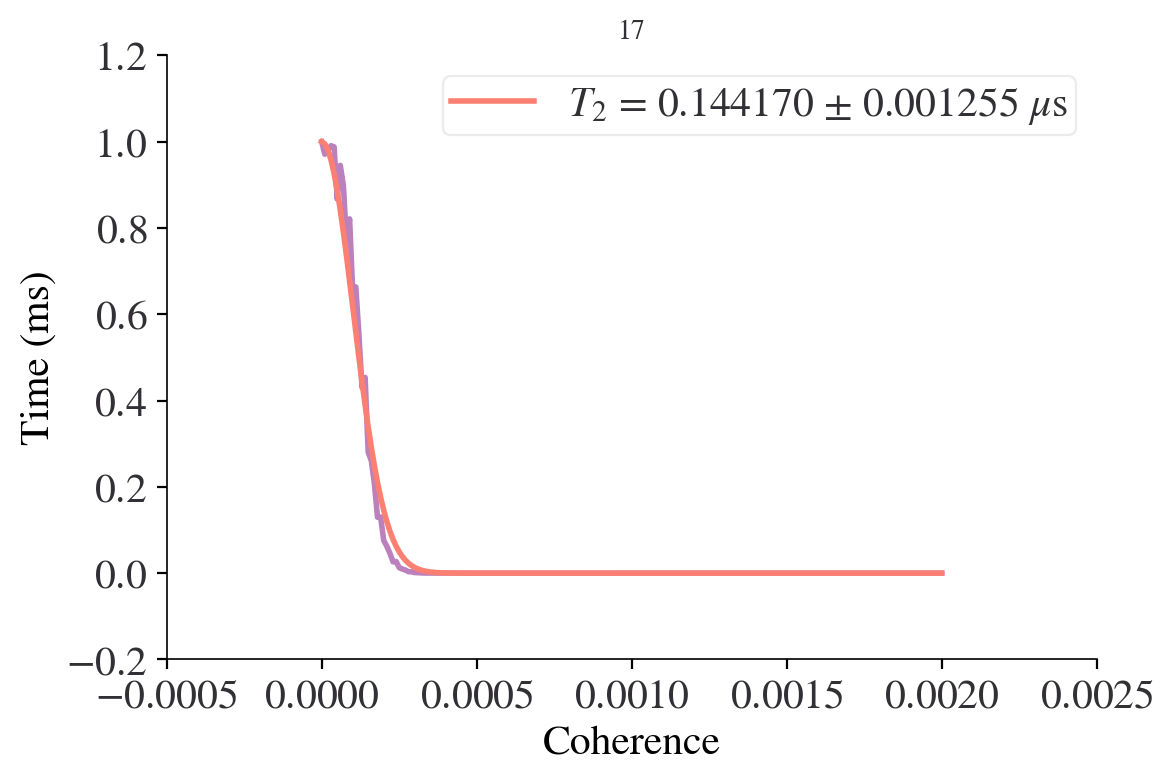

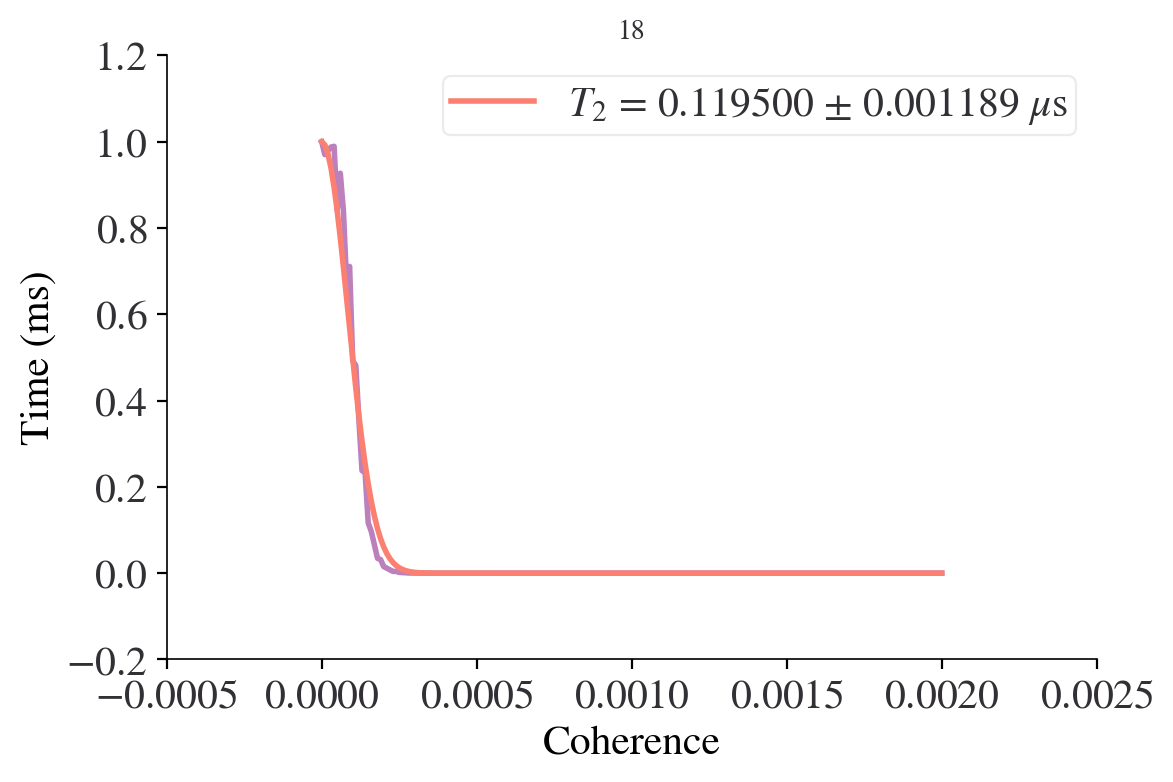

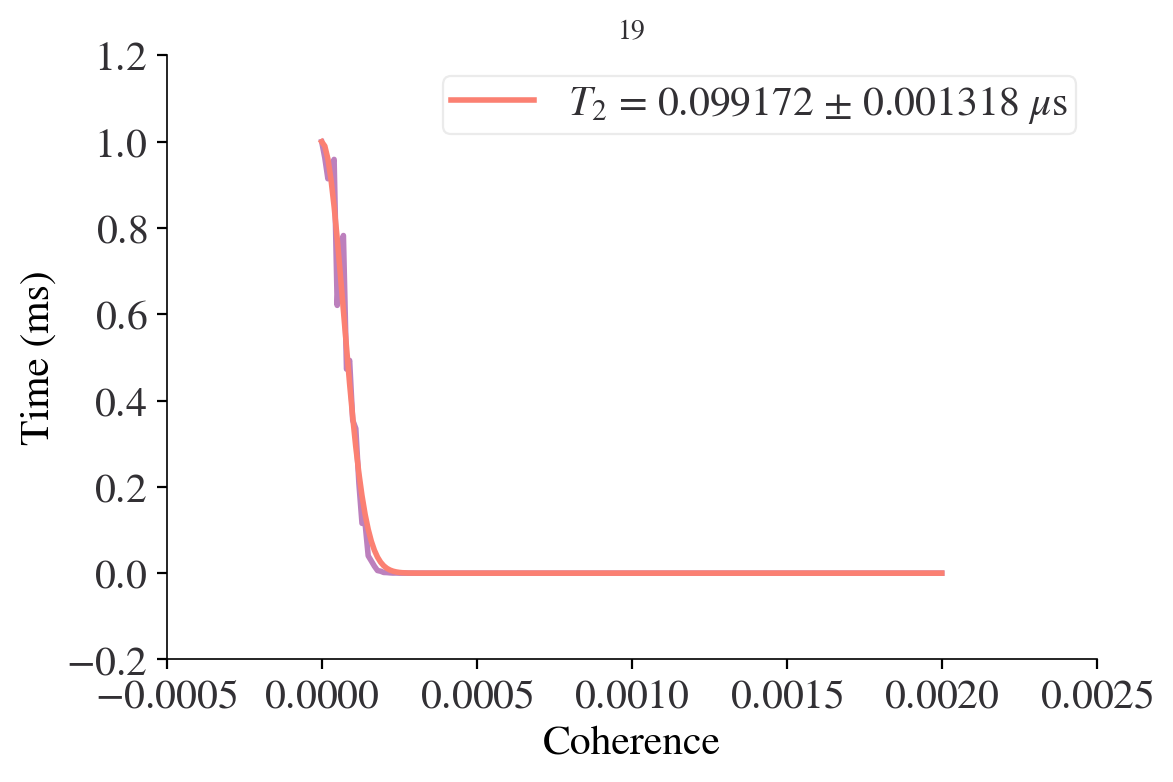

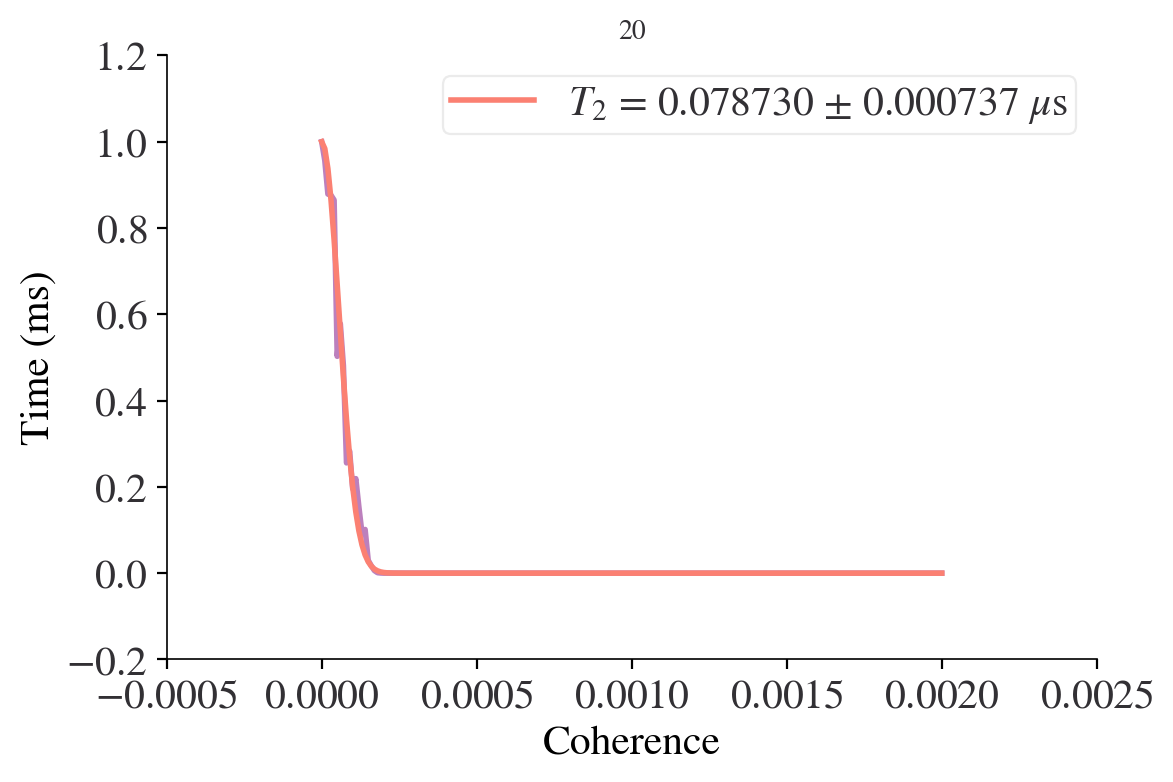

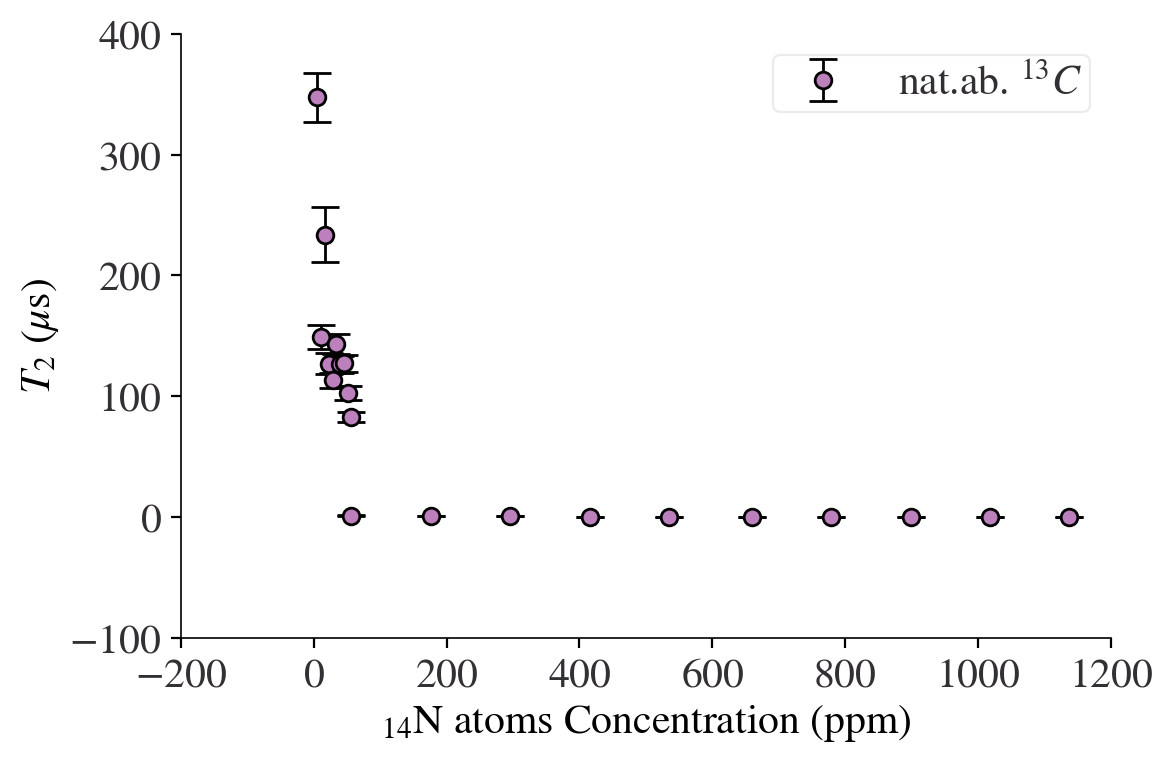

In [3]:
''' import libraries '''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pycce as pc
import ase
import warnings
from mpl_toolkits import mplot3d
from ase.build import bulk
import pycce.filter
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib as mpl
import time

"""set up seed for bath generations"""
seed = 8805
np.random.seed(seed)
seedN = 7000
np.random.seed(seedN)
np.set_printoptions(suppress=True, precision=10)

plt.style.use('plot_style.txt')
# plt.style.use('plot_style.txt')

"fitting a negative squared exponential"

def coherence_fit(x,T2):
    "fit coherence function to a negative squared exponential function with time constant T2"

    fit = np.exp(-(x/T2)**2)

    return fit

bathsize = 100
# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 180  # in A
# Cluster cutoff radius
r_dipole = 50  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

# Mag. Field (Bx By Bz)
b = np.array([0,0,500])  # in G

nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

T2_hahn_rand = []
T2_err_hahn_rand = []
n=0
conc_rand = []

concentration = np.linspace(1e18,1e19,10)

for j in concentration:
    n = n+1
    starttime = time.perf_counter()
    
    ''' generate nitrogens within a 10x10x10 nm^3 cube '''
    nitrogen = pc.random_bath('14N', [100, 100, 100], density=j,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
    nitrogen.zdir = [1,1,1]
    
    ''' generate electrons within a 10x10x10 nm^3 cube '''
    electron = pc.random_bath('e', [100, 100, 100], density=j,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
    electron.zdir = [1,1,1]
    
    'record concentration in ppm'
    conc_rand.append(len(electron)*(3.57**3)/8)
    
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    diamond.add_isotopes(('13C', 0.011))
    
    atoms = diamond.gen_supercell(bathsize, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5])])
    
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,nitrogen,electron]), 
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    time_space = np.linspace(0, 0.1, 201)  # in ms
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_fit = np.abs(T2_gen[0])*1000
    T2_err = T2_var[0][0]*1000
    T2_hahn_rand.append(T2_fit)
    T2_err_hahn_rand.append(T2_err)
    
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)
    
    plt.figure()
    plt.plot(time_space_generatilze_fixed, l_generatilze_fixed)
    plt.plot(time_space,coherence_fit(time_space,T2_gen[0]), label='$T_2$ = {0:0.6f} $\pm$ {1:0.6f} $\mu$s'.format(T2_fit,T2_err))
    plt.xlabel('Coherence')
    plt.ylabel('Time (ms)')
    plt.legend(loc='best')
    plt.title(n)

concentration = np.linspace(1e19, 2e20, 10)
for j in concentration:
    n = n+1
    starttime = time.perf_counter()
    
    ''' generate nitrogens within a 10x10x10 nm^3 cube '''
    nitrogen = pc.random_bath('14N', [100, 100, 100], density=j,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
    nitrogen.zdir = [1,1,1]
    
    ''' generate electrons within a 10x10x10 nm^3 cube '''
    electron = pc.random_bath('e', [100, 100, 100], density=j,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
    electron.zdir = [1,1,1]
    
    'record concentration in ppm'
    conc_rand.append(len(electron)*(3.57**3)/8)
    
    diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
    diamond.zdir = [1,1,1]
    diamond.add_isotopes(('13C', 0.011))
    atoms = diamond.gen_supercell(bathsize, remove=[('C', [0., 0, 0]),
                                               ('C', [0.5, 0.5, 0.5])],
                                  add=[('14N', [0.5, 0.5, 0.5])])
    calc = pc.Simulator(spin=nv, bath=np.concatenate([atoms,nitrogen,electron]), 
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    time_space = np.linspace(0, 0.002, 201)  # in ms
    l_generatilze = calc.compute(time_space, magnetic_field=b,
                          pulses=pulse_sequence,
                          method='gcce', quantity='coherence')
    
    ''' filter faulty points '''
    l_generatilze_test = l_generatilze.real
    
    time_space_generatilze_fixed = []
    l_generatilze_fixed = []
    for i in np.arange(0,201):
        if l_generatilze_test[i] < 1.25 and l_generatilze_test[i] > 0:
            l_generatilze_fixed.append(l_generatilze_test[i])
            time_space_generatilze_fixed.append(time_space[i])
    
    T2_gen,T2_var = curve_fit(coherence_fit,time_space_generatilze_fixed, l_generatilze_fixed)
    T2_var = np.sqrt(np.abs(T2_var))
    T2_fit = np.abs(T2_gen[0])*1000
    T2_err = T2_var[0][0]*1000
    T2_hahn_rand.append(T2_fit)
    T2_err_hahn_rand.append(T2_err)
    
    endtime = time.perf_counter()
    print(starttime-endtime, "secs for calc",n)
    
    plt.figure()
    plt.plot(time_space_generatilze_fixed, l_generatilze_fixed)
    plt.plot(time_space,coherence_fit(time_space,T2_gen[0]), label='$T_2$ = {0:0.6f} $\pm$ {1:0.6f} $\mu$s'.format(T2_fit,T2_err))
    plt.xlabel('Coherence')
    plt.ylabel('Time (ms)')
    plt.legend(loc='best')
    plt.title(n)

datasavefile = 'self_datapoints_T2_mix_conc_rand.csv'
data_mixrand_T2_conc = {'conc_rand':conc_rand,   'T2_hahn_rand':T2_hahn_rand, 'T2_err_hahn_rand':T2_err_hahn_rand}

df = pd.DataFrame(data = data_mixrand_T2_conc)
df.to_csv(datasavefile)

plt.figure()
plt.errorbar(conc_rand, T2_hahn_rand, yerr=T2_err_hahn_rand, fmt='o', ecolor='k', elinewidth=1, capsize=5, label='nat.ab. $^{13}C$')
plt.xlabel('$_{14}$N atoms Concentration (ppm)')
plt.ylabel('$T_2$ ($\mu$s)')
plt.legend()

outpath = 'self_atomnumb_T2_mix_conc_rand.png'
plt.savefig(outpath)

In [170]:
electron = pc.random_bath('e', [100, 100, 100], density=1e18,
                        density_units='cm-3', center=[0,0,0],seed=seedN)
electron.zdir = [1,1,1]

print(len(electron))
print(len(electron)*(3.57**3)/8)

1
5.687411624999999



Bad key "axes.titlelocation" on line 28 in
plot_style.txt.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


    Unnamed: 0    conc_rand  T2_hahn_rand  T2_err_hahn_rand
0            0     5.687412    347.351891         20.015983
1            1    11.374823    148.831989          9.927345
2            2    17.062235    233.848944         22.565709
3            3    22.749647    126.835562          8.581779
4            4    28.437058    113.040101          6.283711
5            5    34.124470    143.098430          8.475063
6            6    39.811881    126.475050          7.072964
7            7    45.499293    127.269533          7.129241
8            8    51.186705    102.771240          5.598839
9            9    56.874116     82.790239          4.250052
10          10    56.874116      1.254299          0.026509
11          11   176.309760      0.629690          0.007737
12          12   295.745404      0.459105          0.005383
13          13   415.181049      0.392838          0.003557
14          14   534.616693      0.233255          0.001102
15          15   659.739748      0.18393

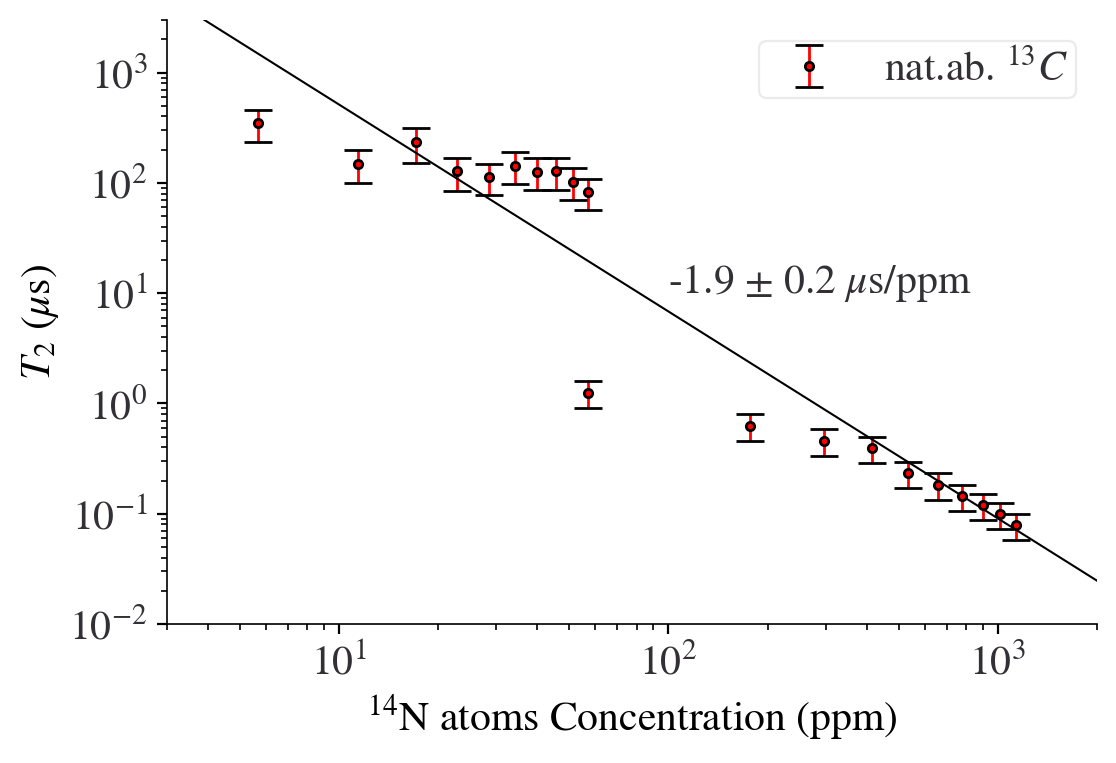

In [29]:
plt.style.use('plot_style.txt')
# mpl.rcParams['figure.figsize'] = [12.0, 8.0]
# mpl.rcParams['xtick.labelsize'] = 15

data = pd.read_csv(datasavefile)
print(data)

T2_popfiterror = 0.26045948996093372
T2_N_trueerr = T2_err_hahn_rand + np.multiply(T2_hahn_rand,T2_popfiterror)

fit_N,fit_COV = np.polyfit(np.log(conc_rand), np.log(T2_hahn_rand),1,full = False, cov = True)
print(fit_N)
print(fit_COV)
fit_err_N = np.sqrt(fit_COV[0][0])
print(fit_err_N)

X = np.linspace(2,2000,200)
Y_N = np.exp(fit_N[1])*(X**fit_N[0])

# def conc_fit(x,a,n):
#     "fit coherence function to a negative squared exponential function with time constant T2"
    
#     fit = a/(x)**n
    
#     return fit

# popt,pcov = curve_fit(conc_fit, conc_rand, T2_hahn_rand)

# print(popt)
# print(np.sqrt(pcov))

# xfit = np.linspace(2,2000,200)
# yfit = conc_fit(xfit,popt[0],popt[1])

plt.figure()
plt.plot(X,Y_N, 'k',linewidth=0.75)
# plt.plot(xfit, yfit, 'k',linewidth=0.75)
plt.errorbar(conc_rand, T2_hahn_rand, yerr=T2_N_trueerr, fmt='r.', ecolor='r', elinewidth=1, capsize=5, label='nat.ab. $^{13}C$')
plt.xlabel('$^{14}$N atoms Concentration (ppm)')
plt.ylabel('$T_2$ ($\mu$s)')
plt.yscale('log')
plt.xscale('log')
plt.xlim(3,2000)
plt.ylim(0.01,3000)
plt.text(100,10, r'-1.9 $\pm$ 0.2 $\mu$s/ppm')
plt.legend()

outpath = 'self_atomnumb_T2_mix_conc_rand.png'
plt.savefig(outpath)